In [ ]:
import kagglehub
sampadab17_network_intrusion_detection_path = kagglehub.dataset_download('sampadab17/network-intrusion-detection')

print('Data source import complete.')

100%|██████████| 818k/818k [00:00<00:00, 30.4MB/s]

Extracting files...
Data source import complete.


# Imports & Configs

In [ ]:
%pip install numpy pandas seaborn matplotlib optuna sklearn xgboost catboost lightgbm > /dev/null 2>&1

In [ ]:
!pip install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 5.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.api.types import is_numeric_dtype
import warnings
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree  import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import BernoulliNB
from lightgbm import LGBMClassifier
from sklearn.feature_selection import RFE
import itertools
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from tabulate import tabulate
import os
warnings.filterwarnings('ignore')
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Data Preprocessing & EDA

In [ ]:
import os
# The data was downloaded to sampadab17_network_intrusion_detection_path
# Let's list the files in the extracted directory to find the correct paths
print(os.listdir(sampadab17_network_intrusion_detection_path))

train=pd.read_csv(os.path.join(sampadab17_network_intrusion_detection_path, 'Train_data.csv'))
test=pd.read_csv(os.path.join(sampadab17_network_intrusion_detection_path, 'Test_data.csv'))
train

['Test_data.csv', 'Train_data.csv']


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25187,0,tcp,exec,RSTO,0,0,0,0,0,0,...,7,0.03,0.06,0.00,0.00,0.00,0.00,1.00,1.00,anomaly
25188,0,tcp,ftp_data,SF,334,0,0,0,0,0,...,39,1.00,0.00,1.00,0.18,0.00,0.00,0.00,0.00,anomaly
25189,0,tcp,private,REJ,0,0,0,0,0,0,...,13,0.05,0.07,0.00,0.00,0.00,0.00,1.00,1.00,anomaly
25190,0,tcp,nnsp,S0,0,0,0,0,0,0,...,20,0.08,0.06,0.00,0.00,1.00,1.00,0.00,0.00,anomaly


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25192 entries, 0 to 25191
Data columns (total 42 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     25192 non-null  int64  
 1   protocol_type                25192 non-null  object 
 2   service                      25192 non-null  object 
 3   flag                         25192 non-null  object 
 4   src_bytes                    25192 non-null  int64  
 5   dst_bytes                    25192 non-null  int64  
 6   land                         25192 non-null  int64  
 7   wrong_fragment               25192 non-null  int64  
 8   urgent                       25192 non-null  int64  
 9   hot                          25192 non-null  int64  
 10  num_failed_logins            25192 non-null  int64  
 11  logged_in                    25192 non-null  int64  
 12  num_compromised              25192 non-null  int64  
 13  root_shell      

In [ ]:
train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [ ]:
train.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,25192.000000,2.519200e+04,2.519200e+04,25192.000000,25192.000000,25192.00000,25192.000000,25192.000000,25192.000000,25192.000000,...,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000
mean,305.054104,2.433063e+04,3.491847e+03,0.000079,0.023738,0.00004,0.198039,0.001191,0.394768,0.227850,...,182.532074,115.063036,0.519791,0.082539,0.147453,0.031844,0.285800,0.279846,0.117800,0.118769
std,2686.555640,2.410805e+06,8.883072e+04,0.008910,0.260221,0.00630,2.154202,0.045418,0.488811,10.417352,...,98.993895,110.646850,0.448944,0.187191,0.308367,0.110575,0.445316,0.446075,0.305869,0.317333
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,84.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,255.000000,61.000000,0.510000,0.030000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,2.790000e+02,5.302500e+02,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,...,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000
max,42862.000000,3.817091e+08,5.151385e+06,1.000000,3.000000,1.00000,77.000000,4.000000,1.000000,884.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Missing Data

In [ ]:
total = train.shape[0]
missing_columns = [col for col in train.columns if train[col].isnull().sum() > 0]
for col in missing_columns:
    null_count = train[col].isnull().sum()
    per = (null_count/total) * 100
    print(f"{col}: {null_count} ({round(per, 3)}%)")

## Duplicates

In [ ]:
print(f"Number of duplicate rows: {train.duplicated().sum()}")

Number of duplicate rows: 0


In [ ]:
df = train.copy()

## Outliers

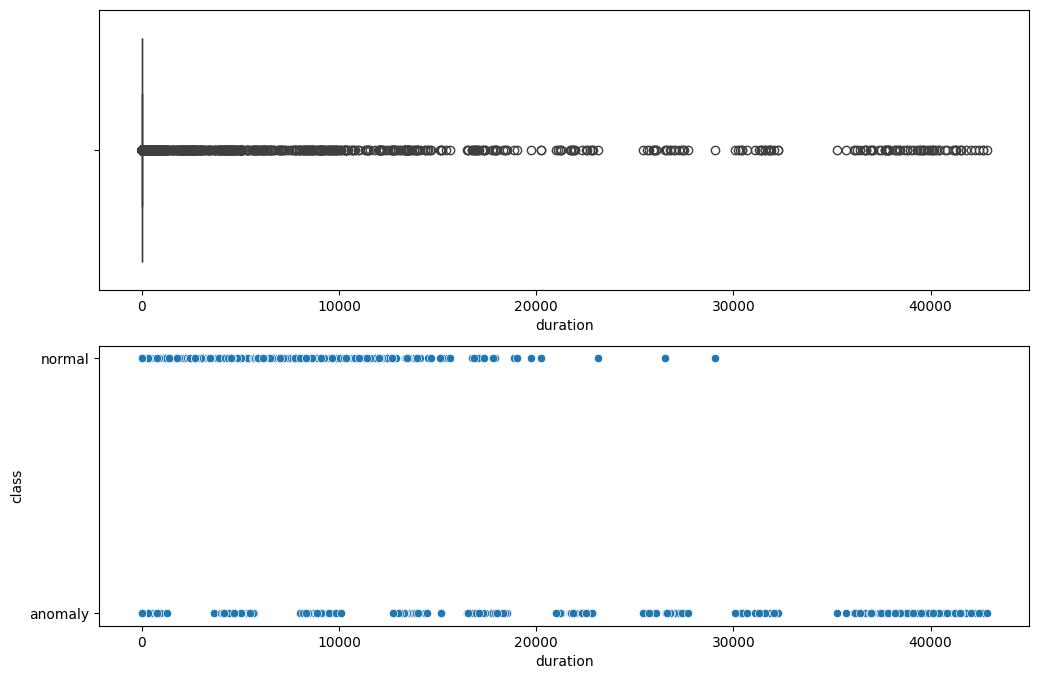

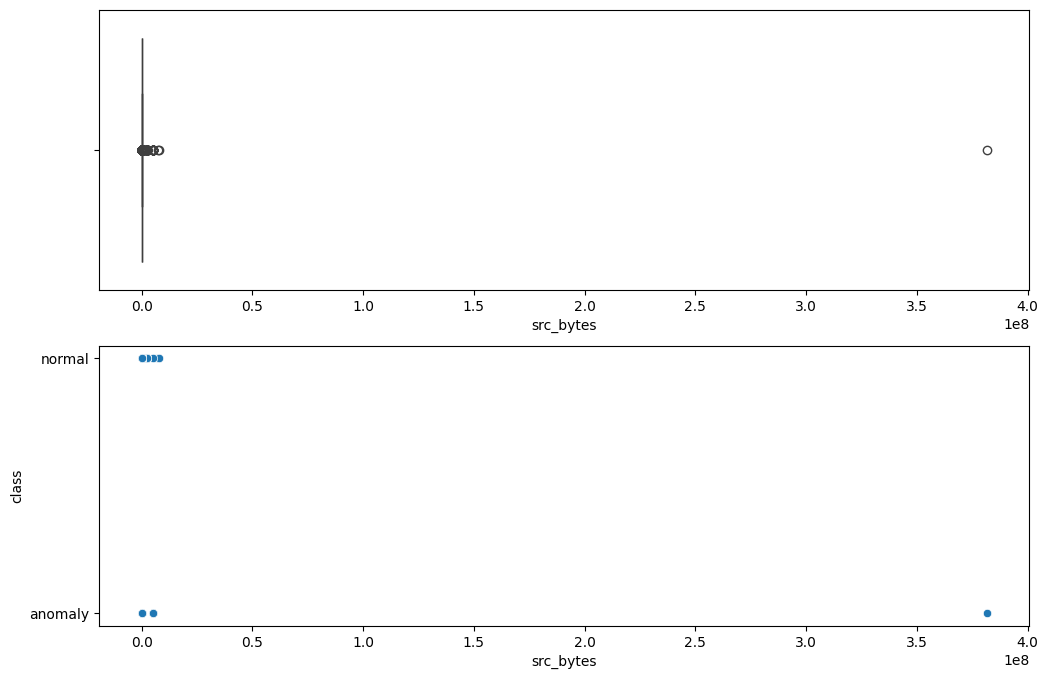

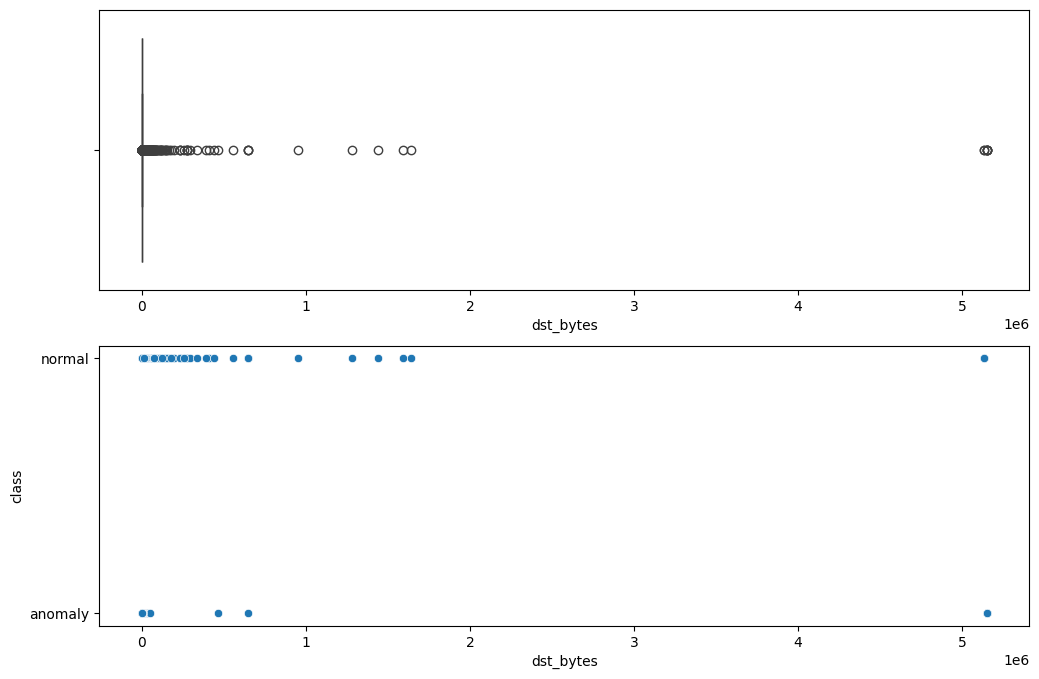

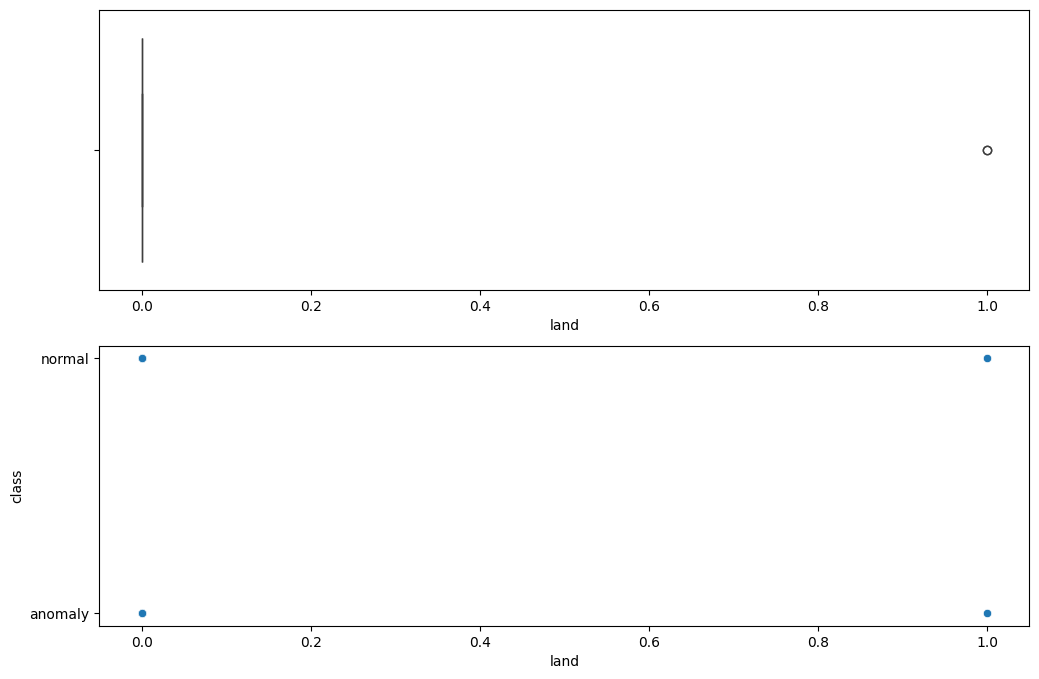

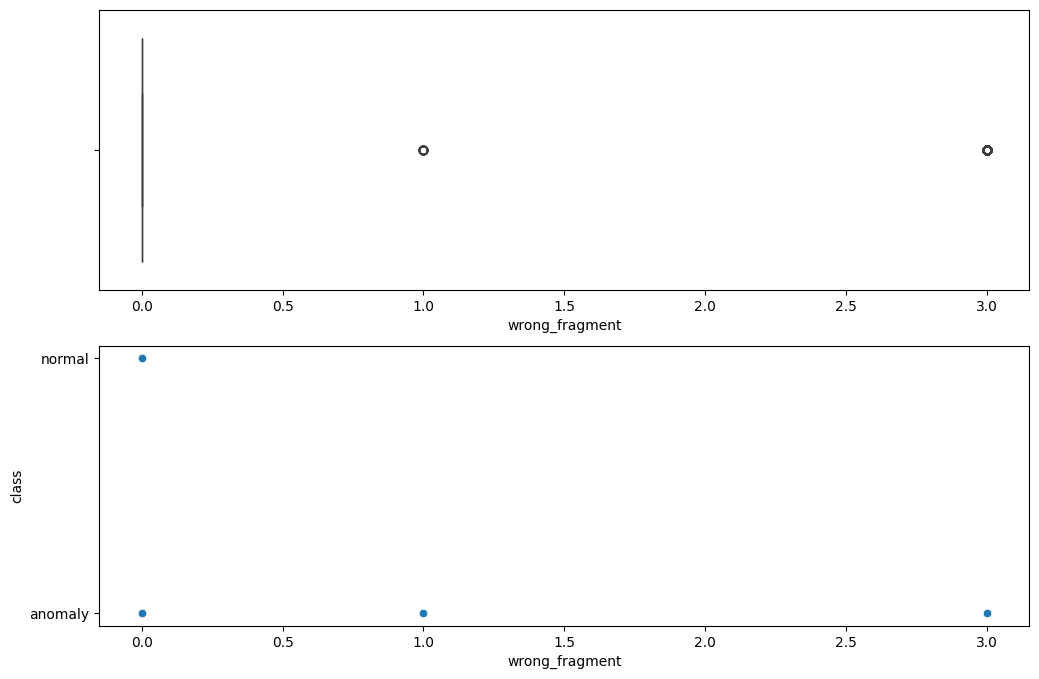

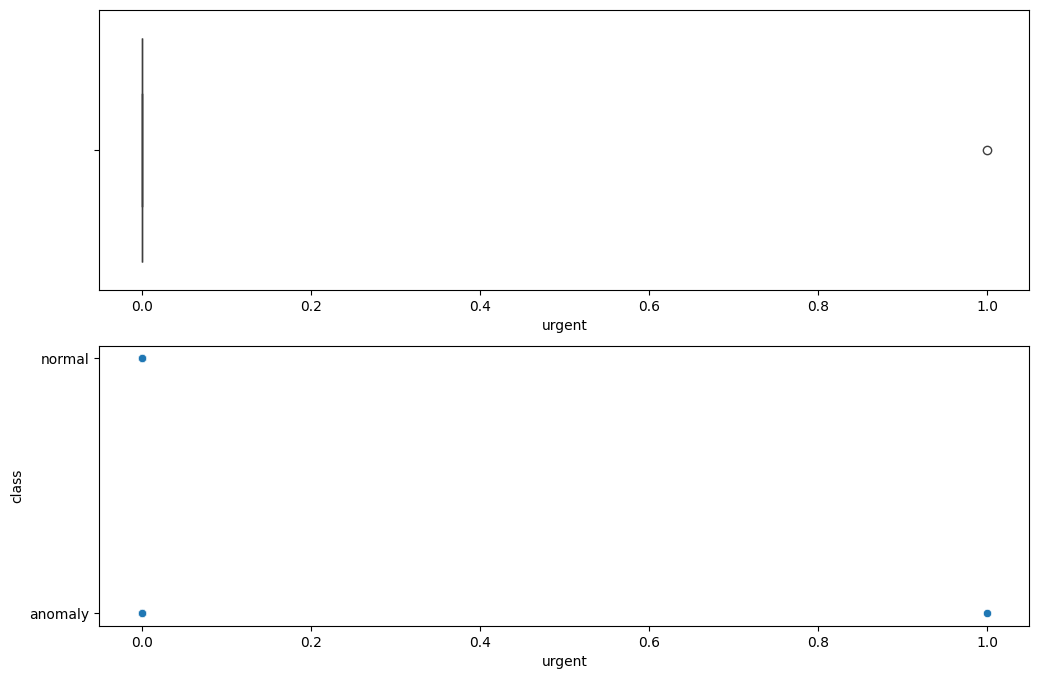

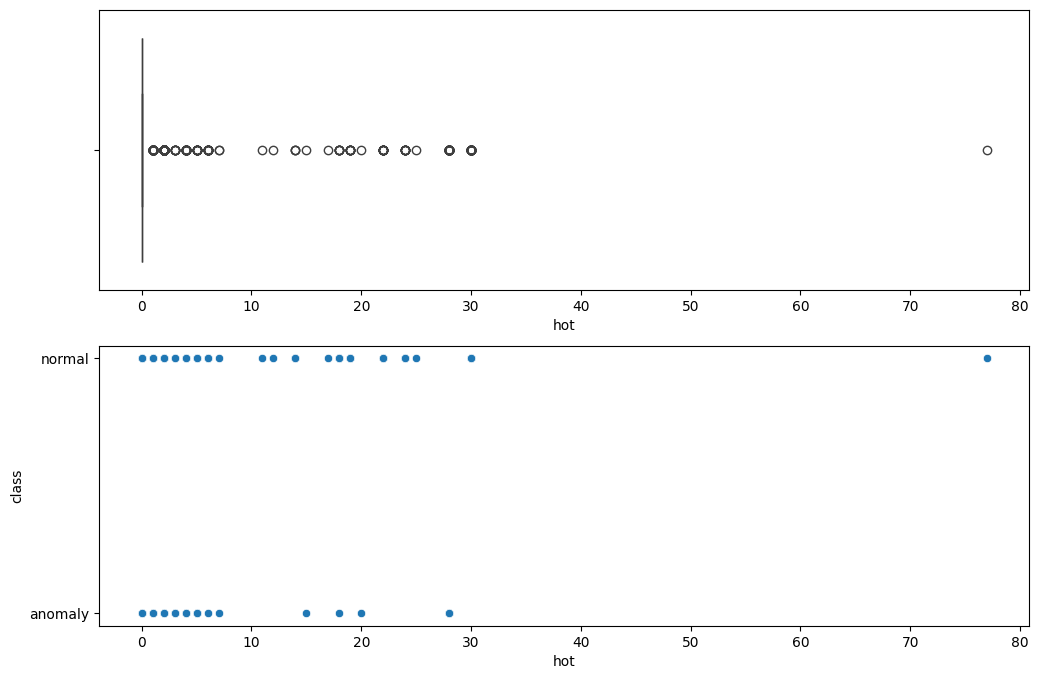

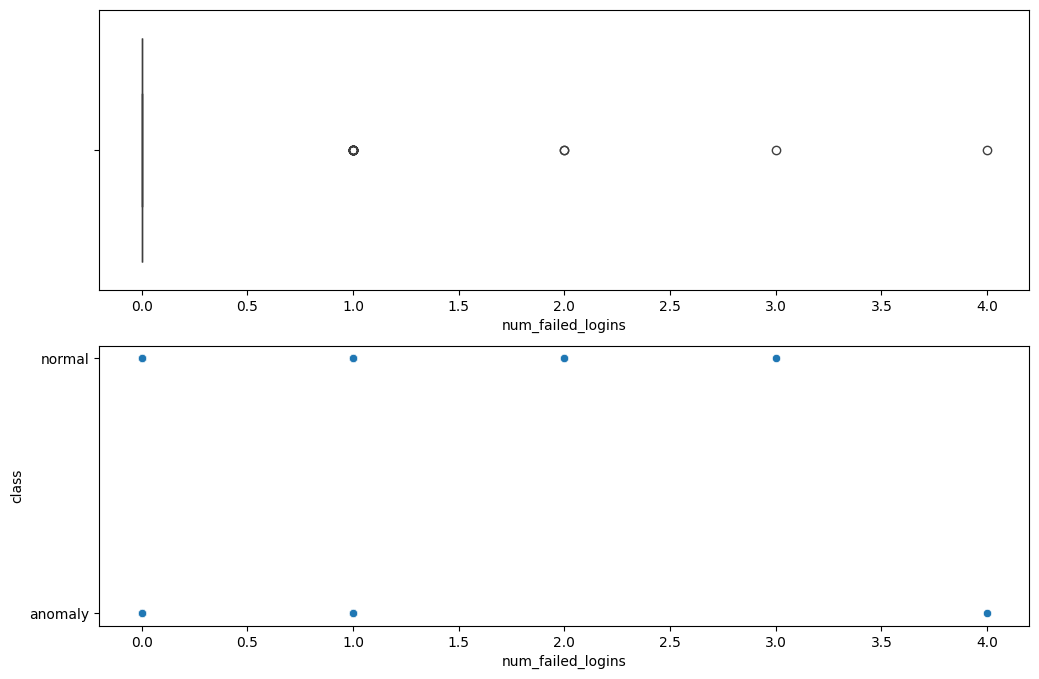

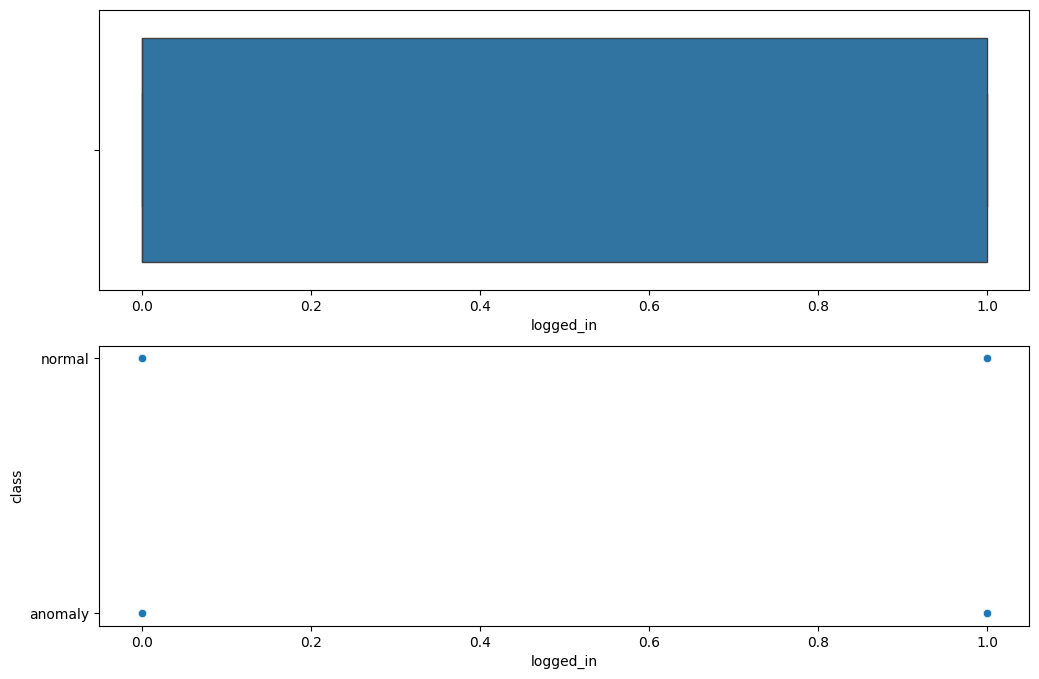

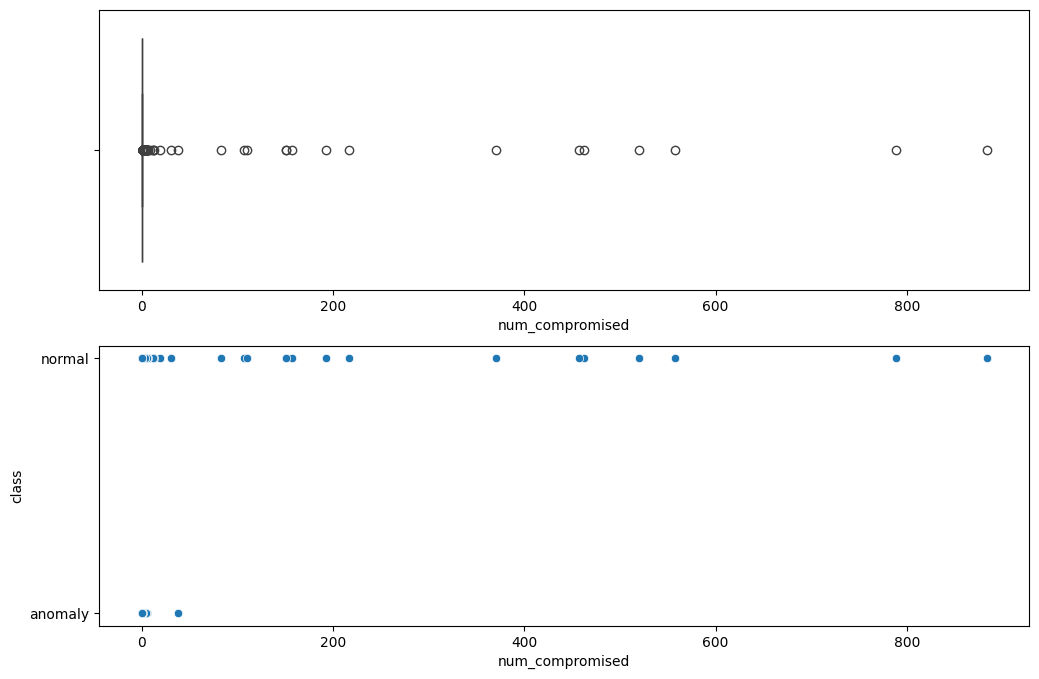

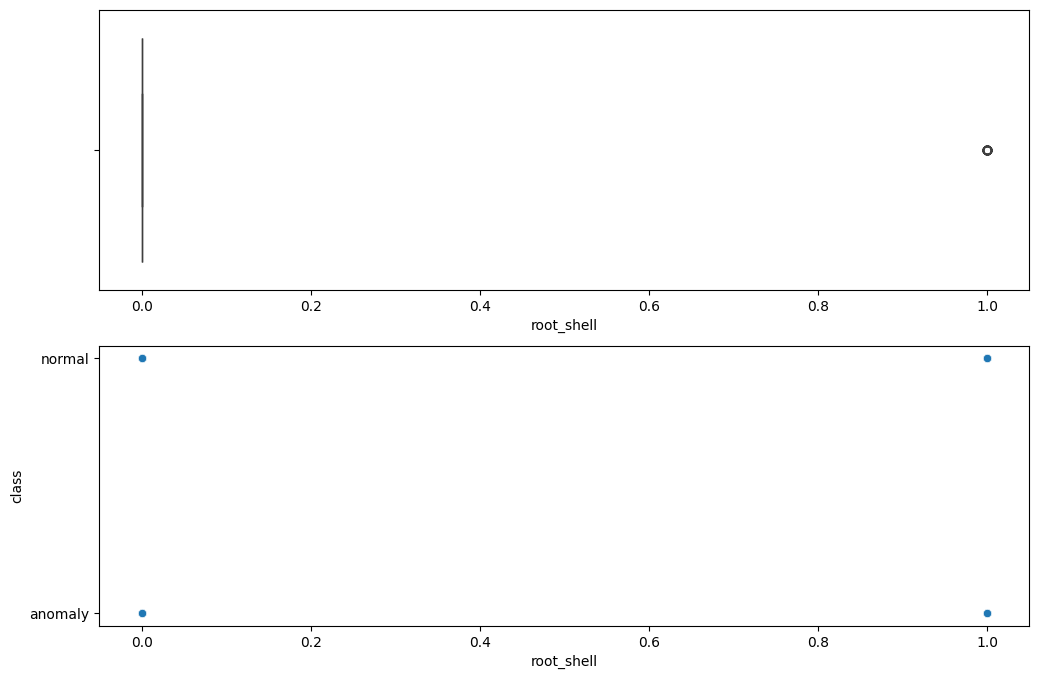

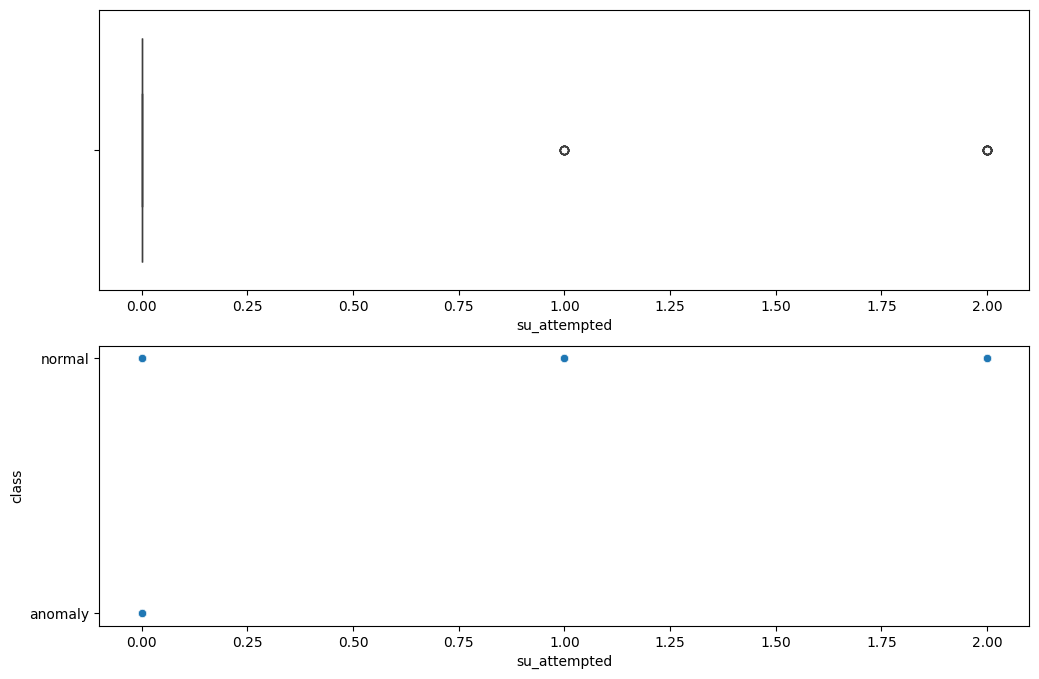

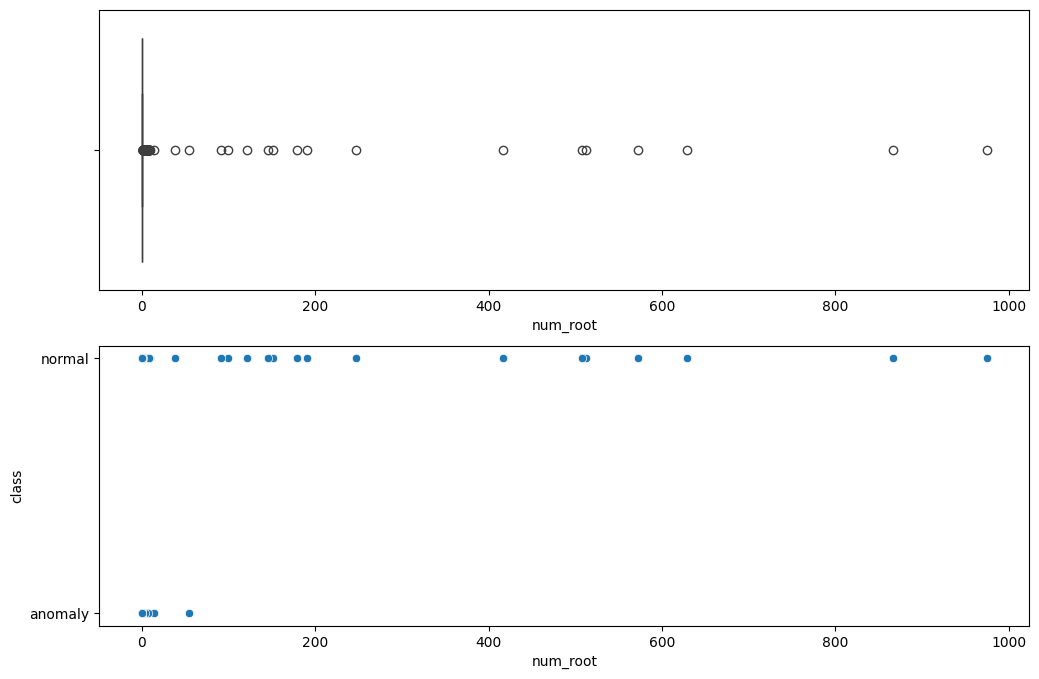

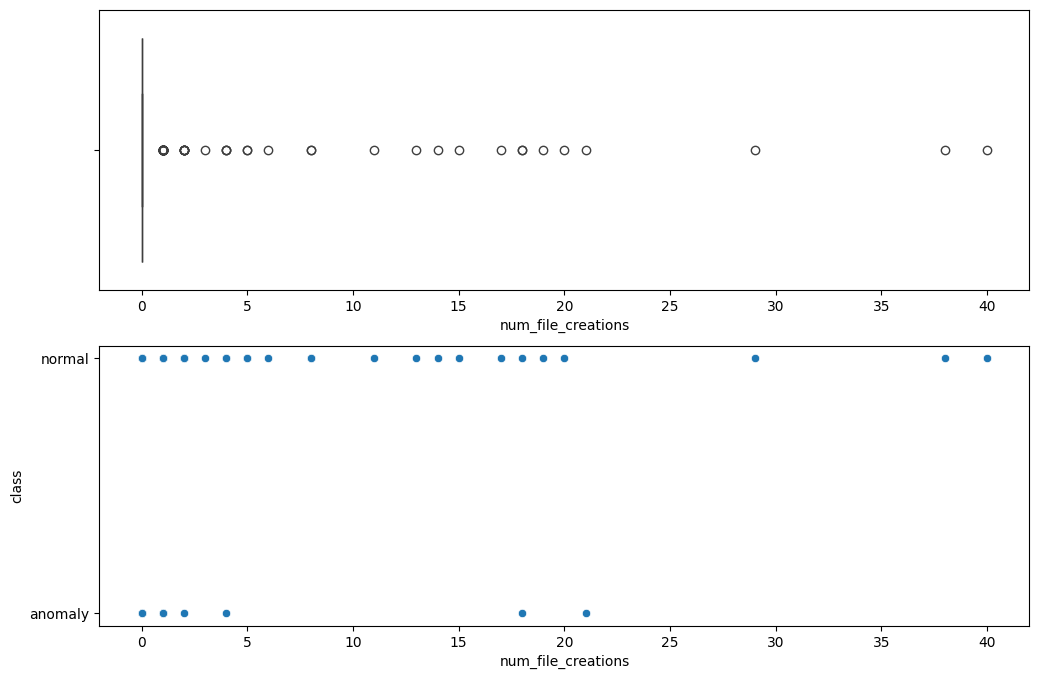

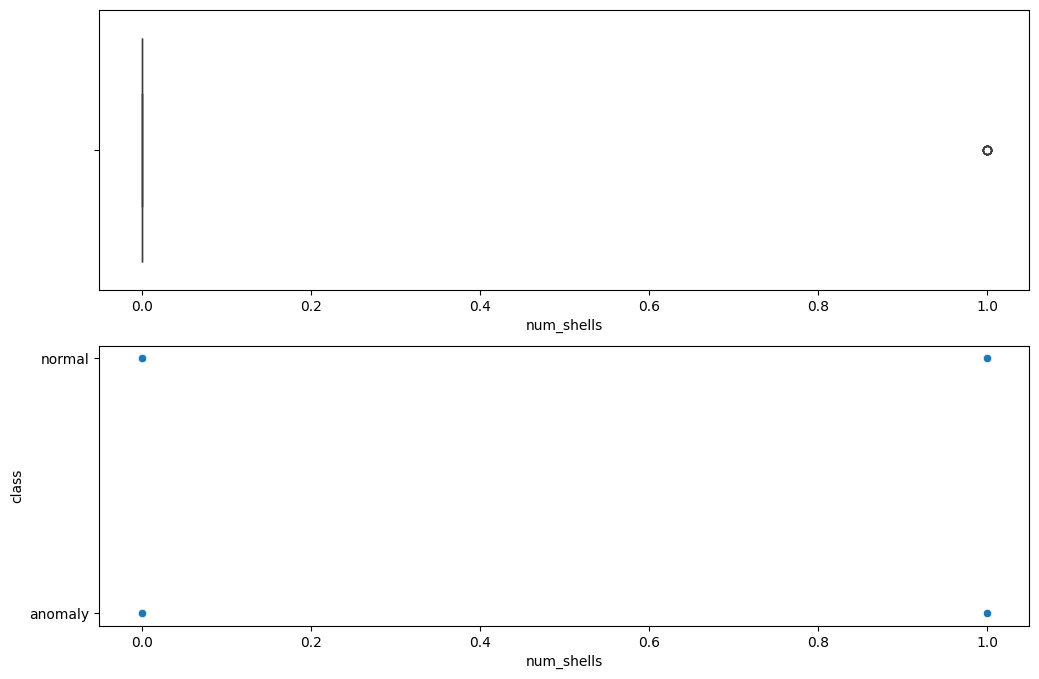

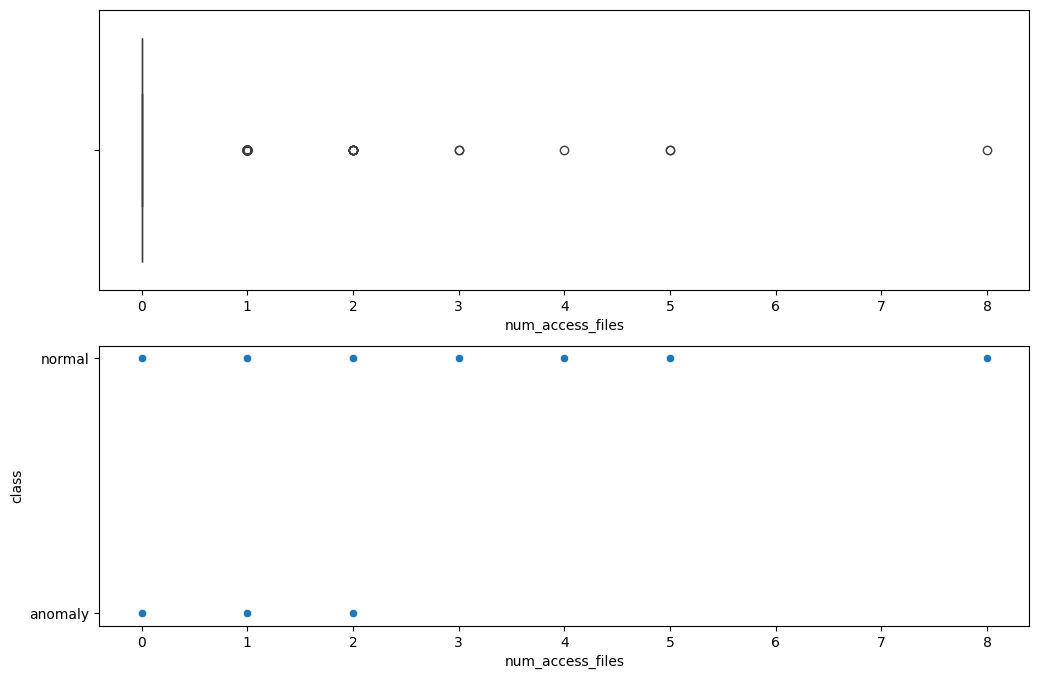

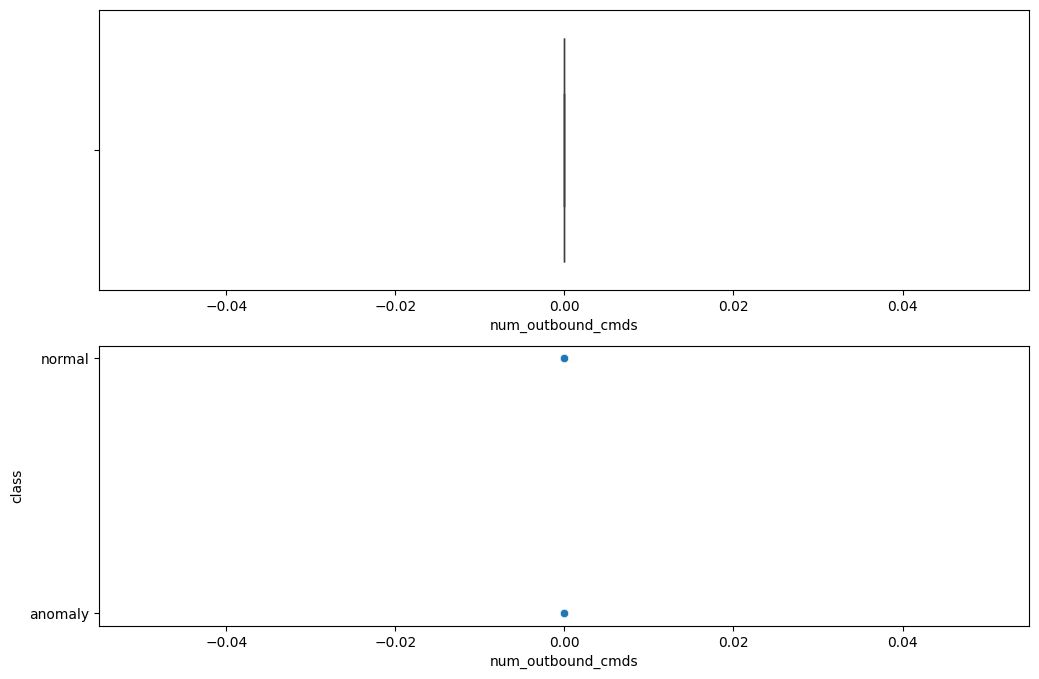

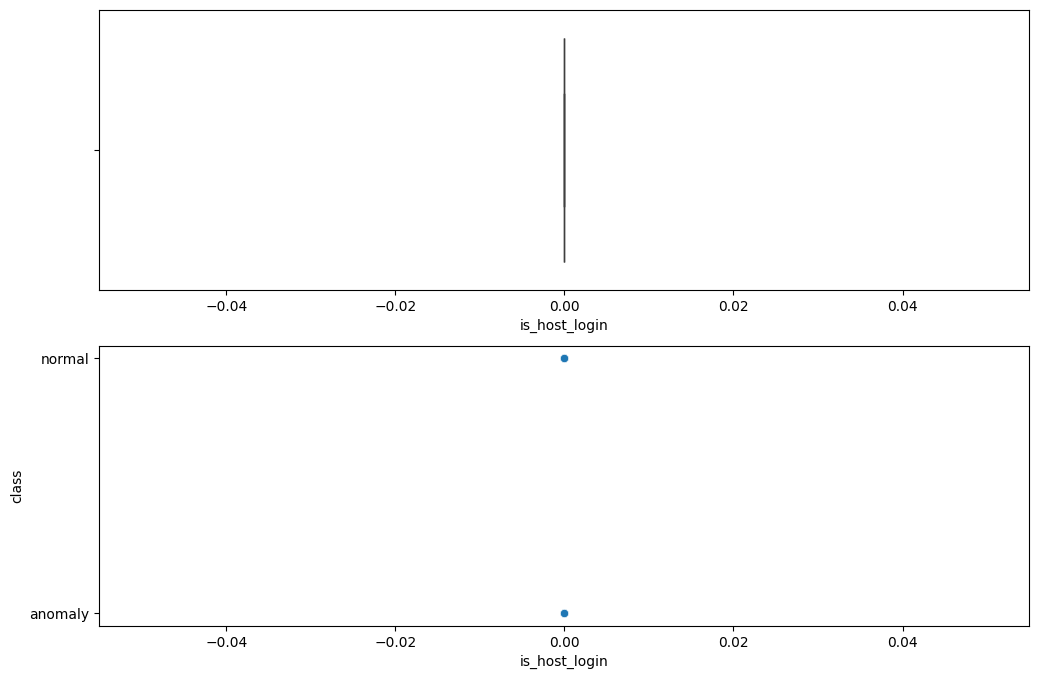

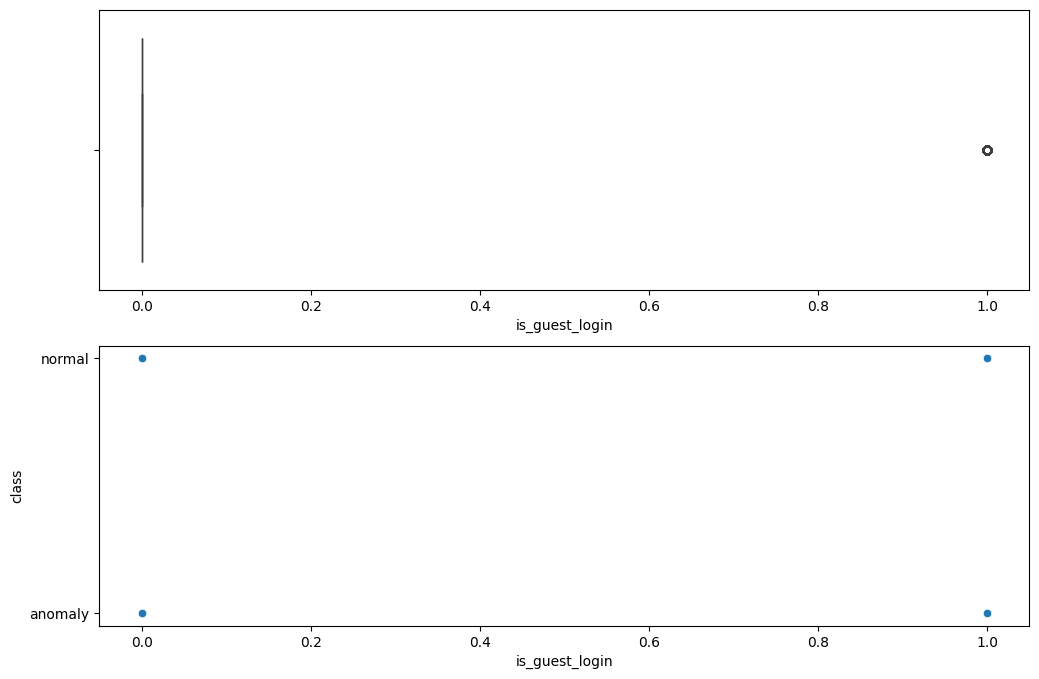

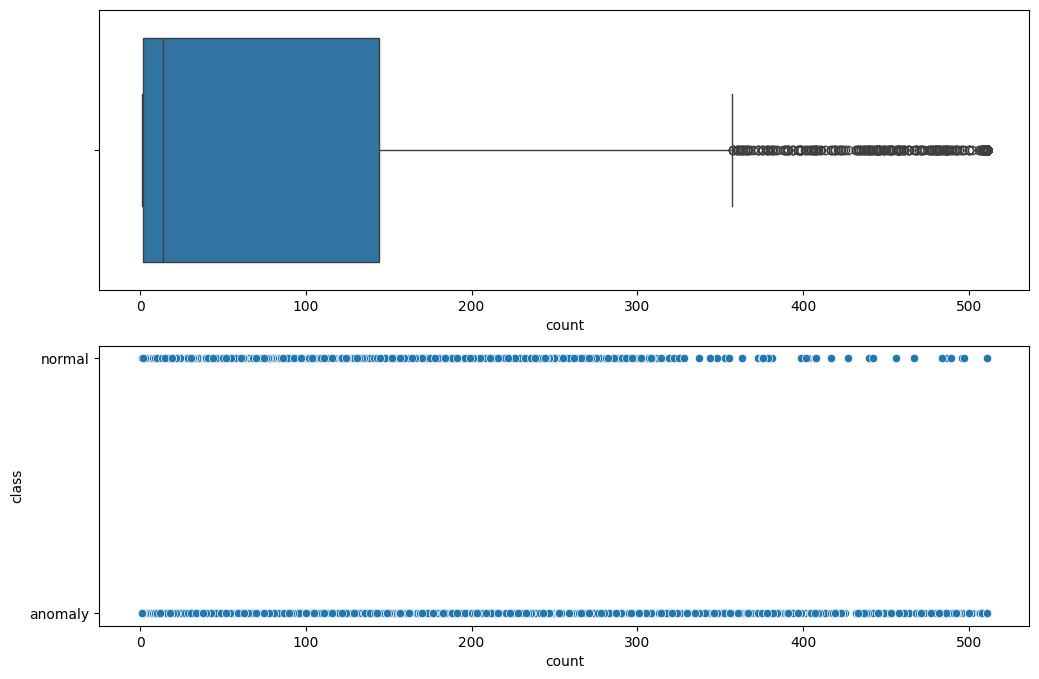

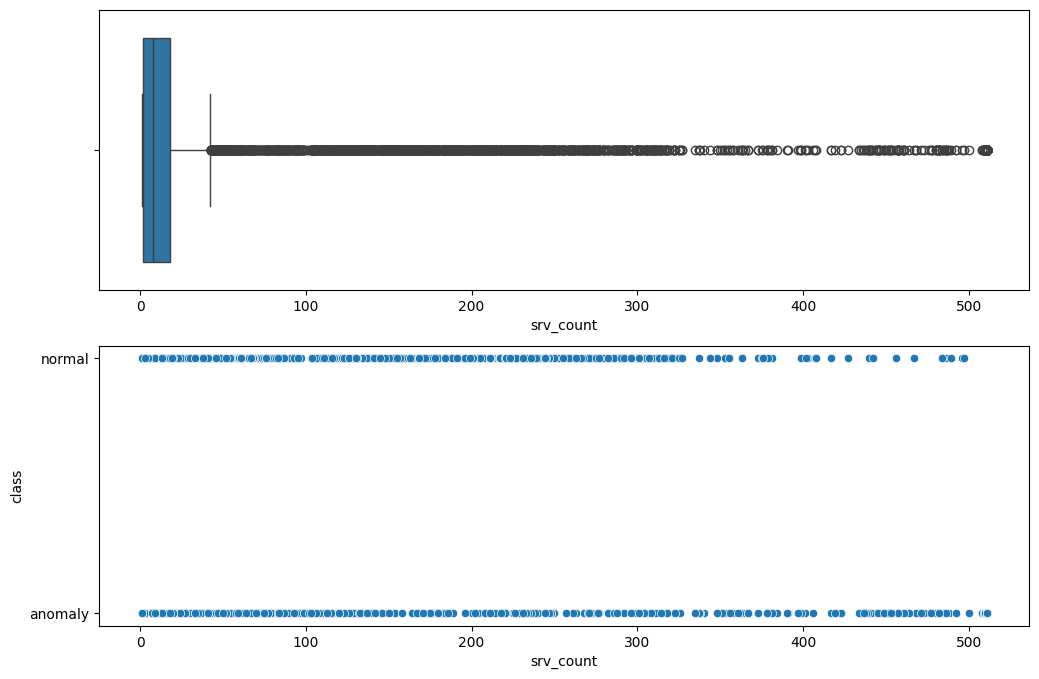

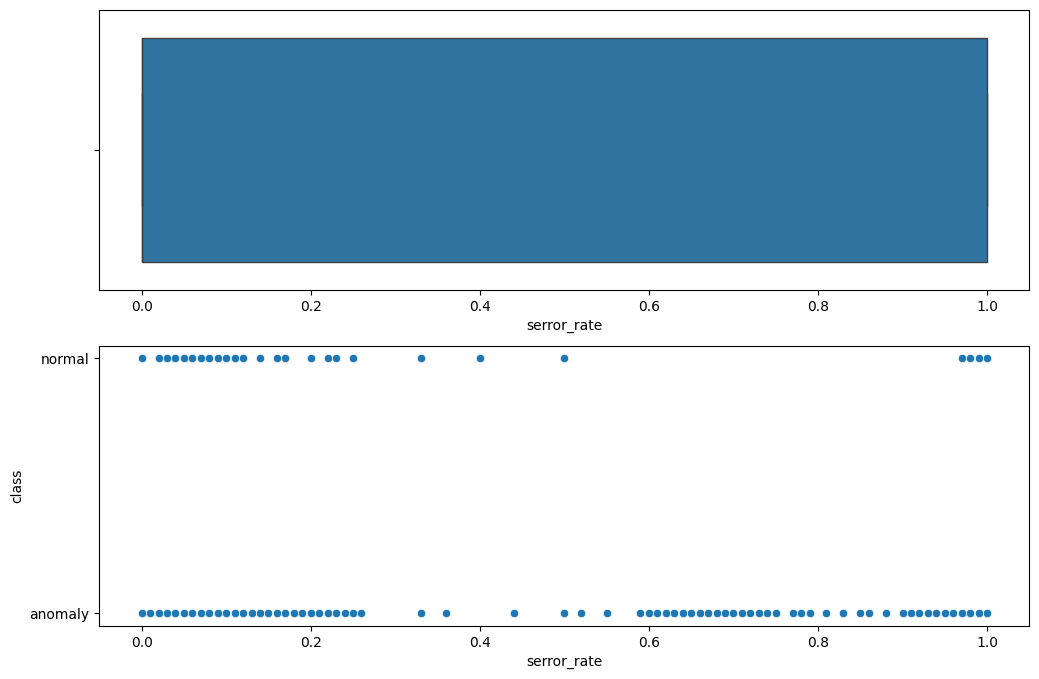

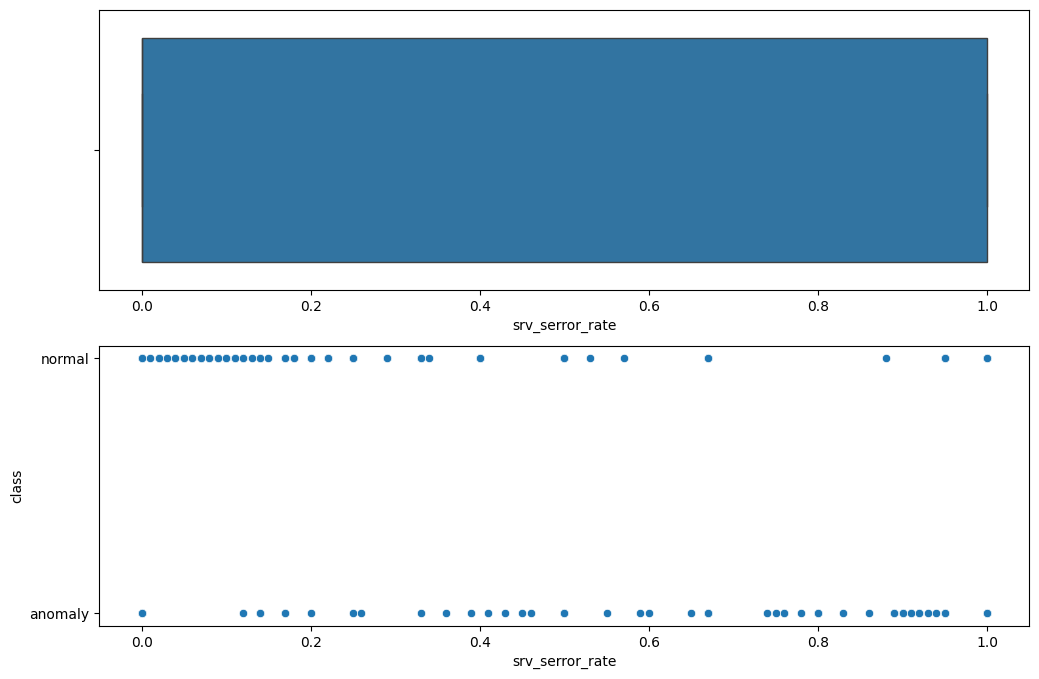

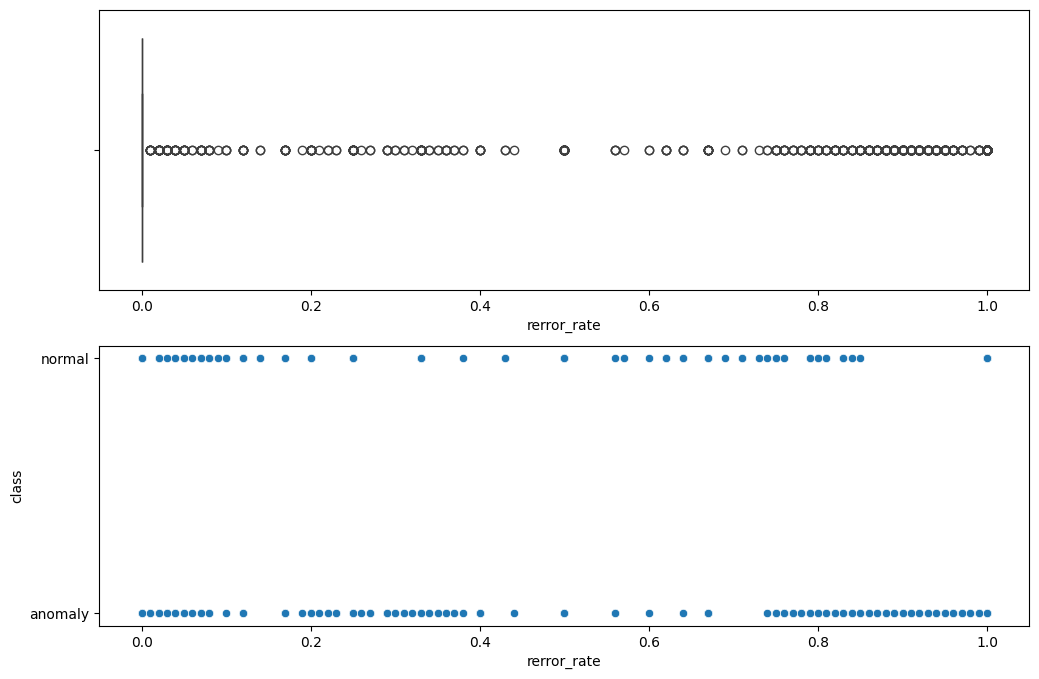

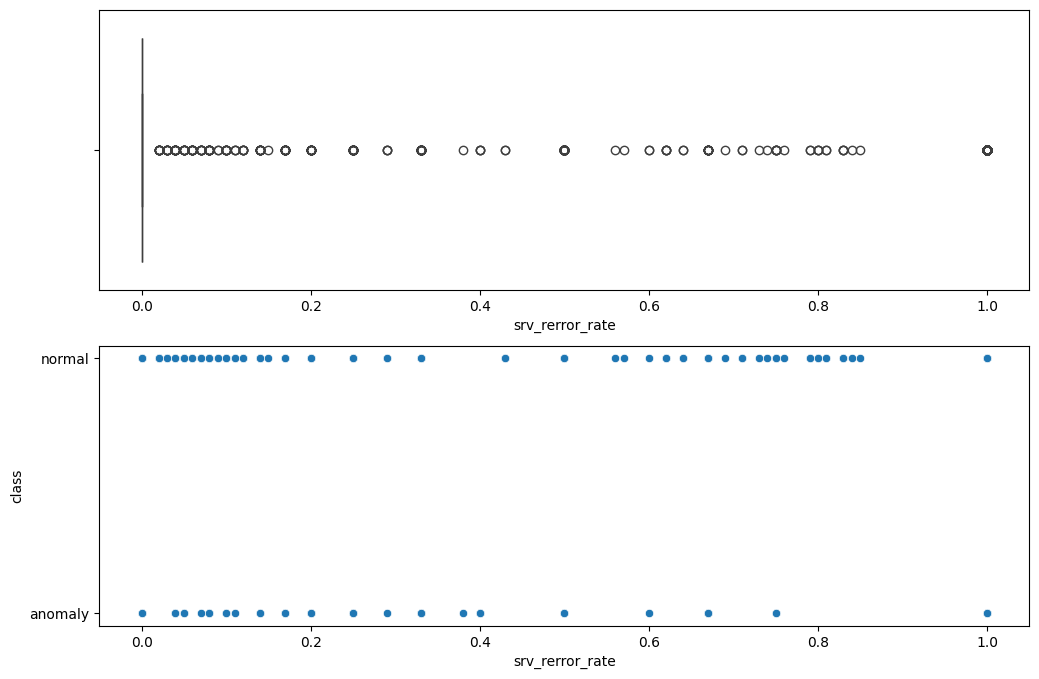

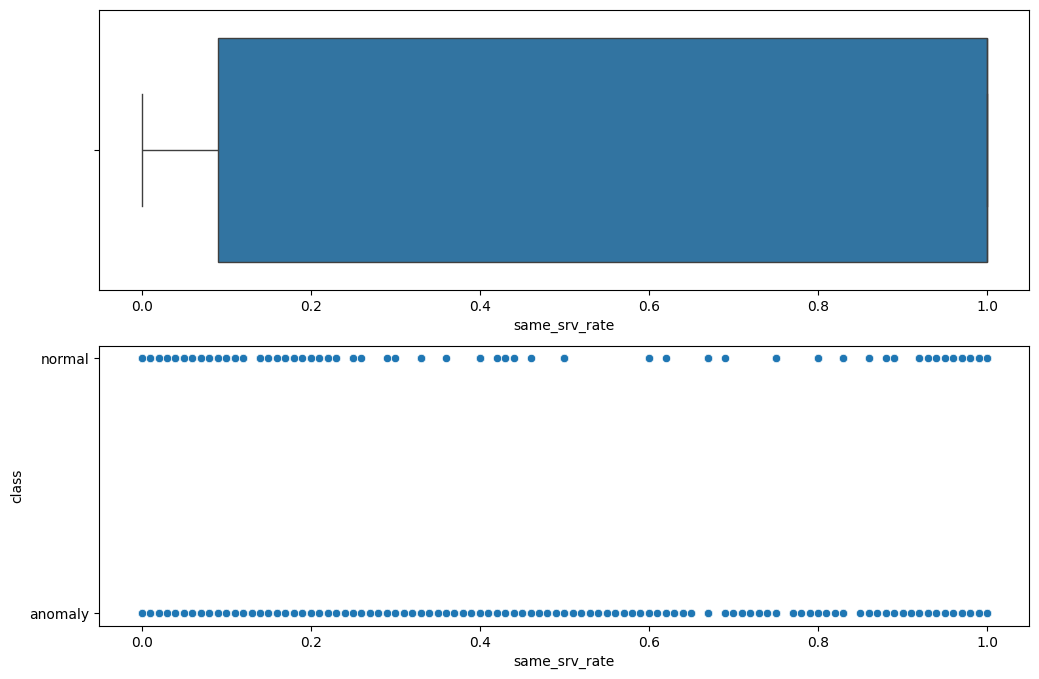

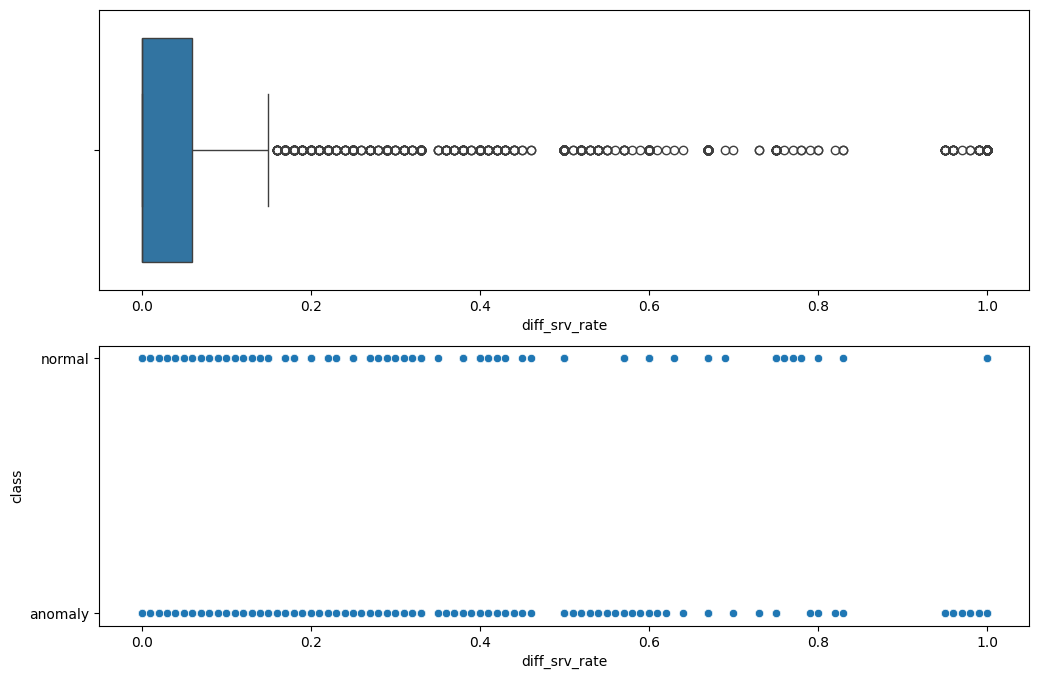

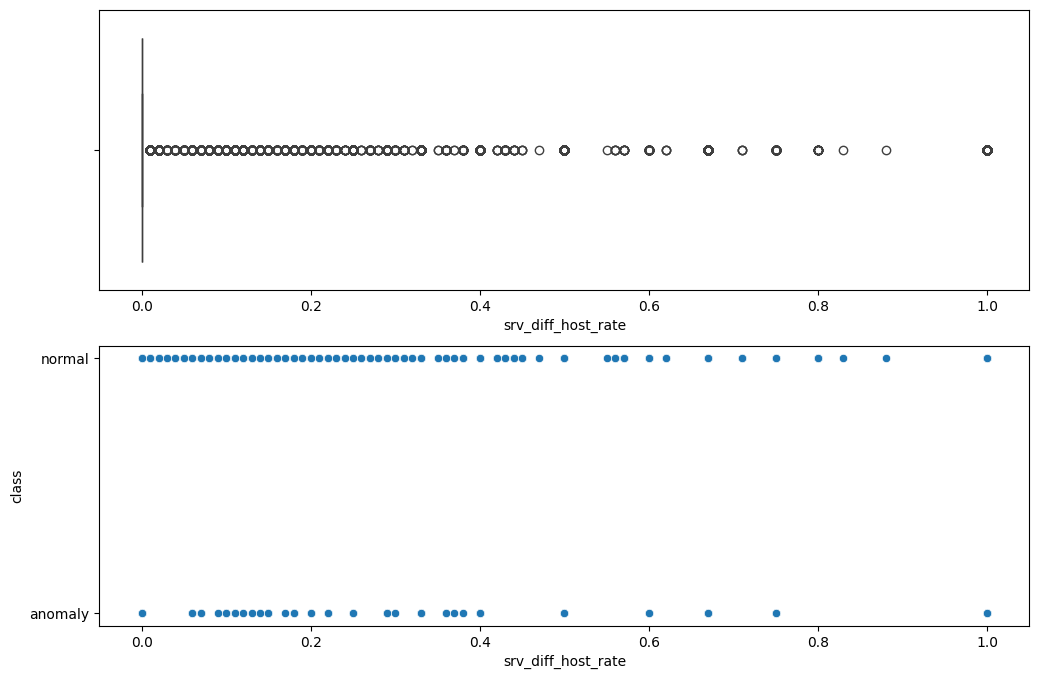

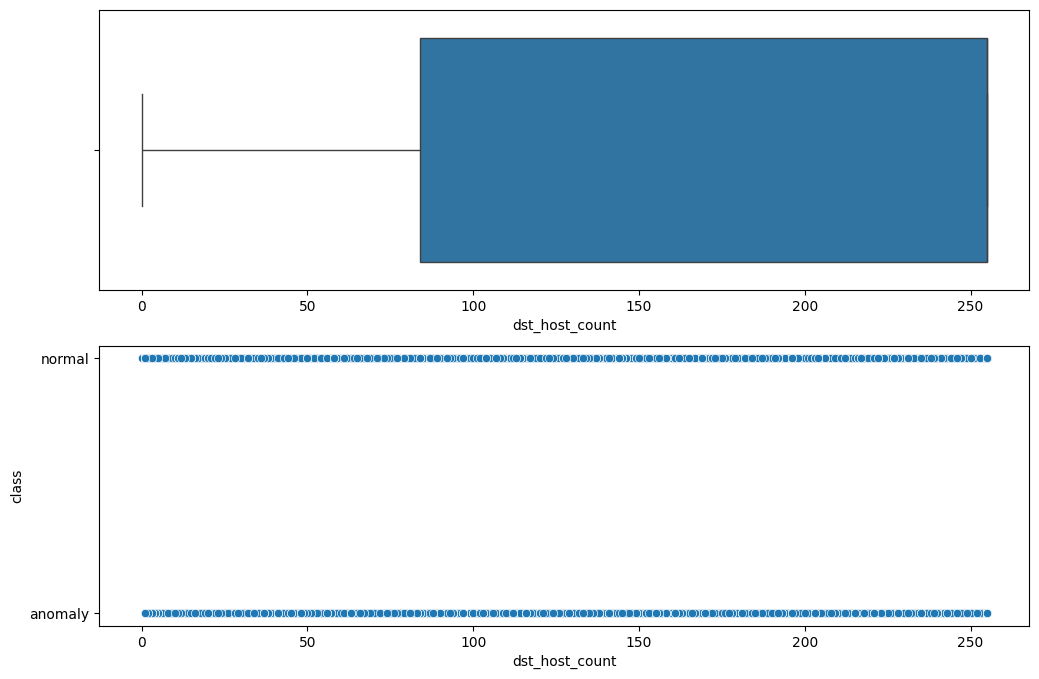

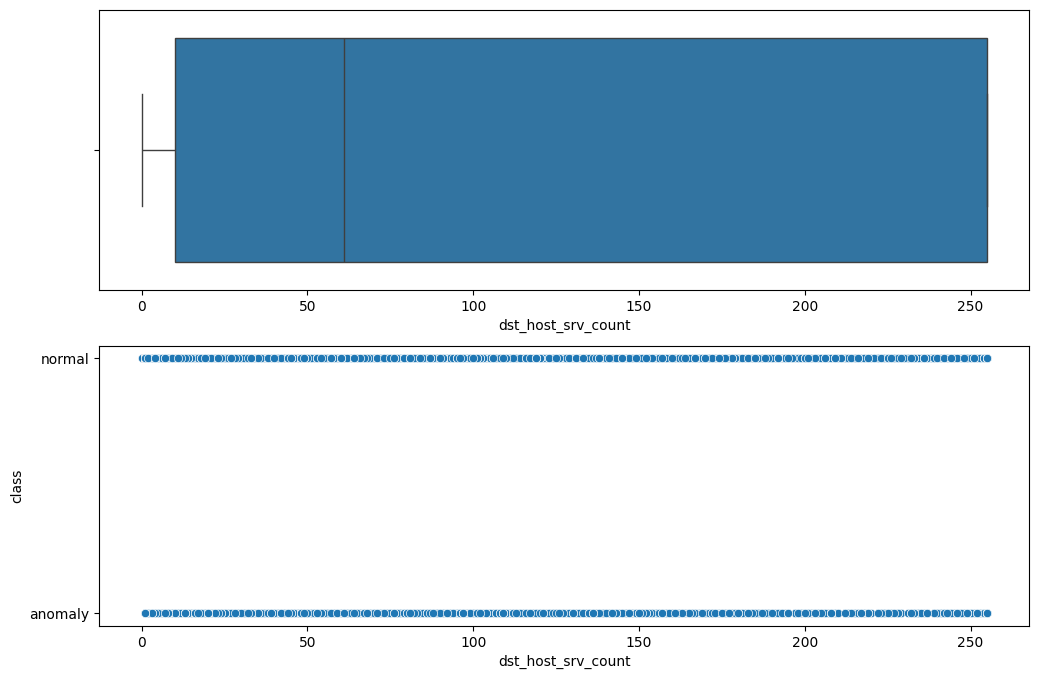

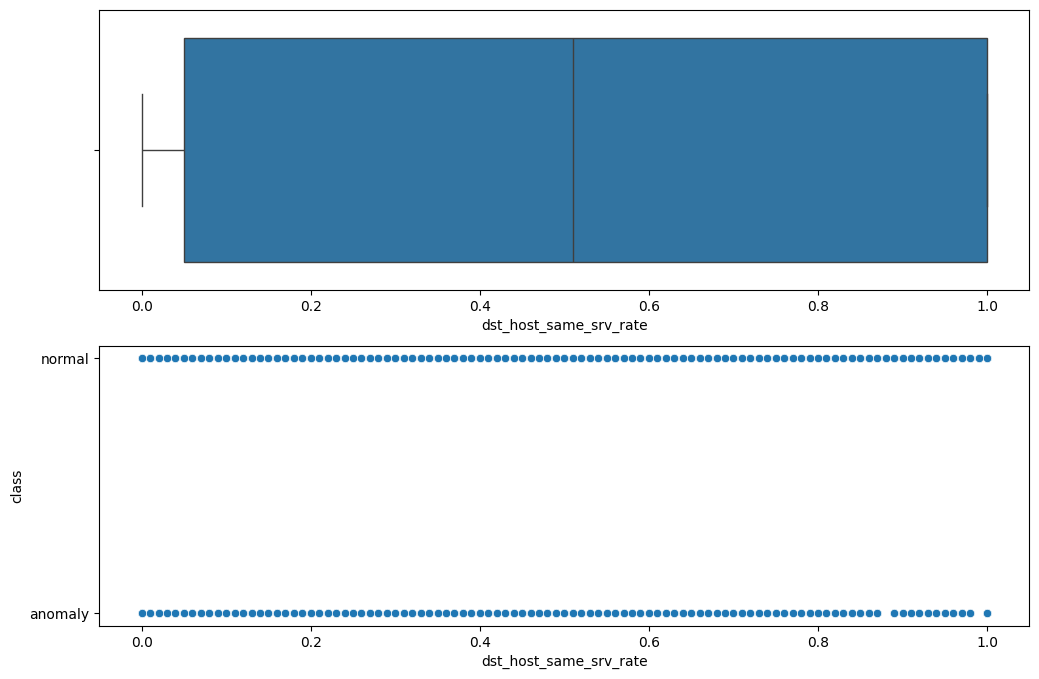

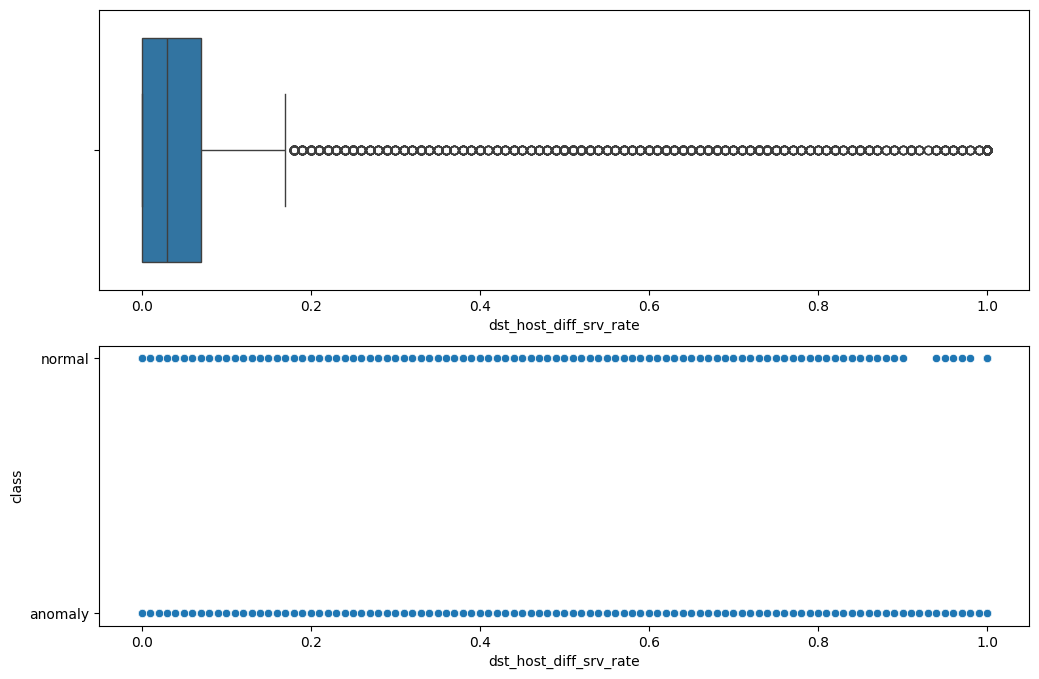

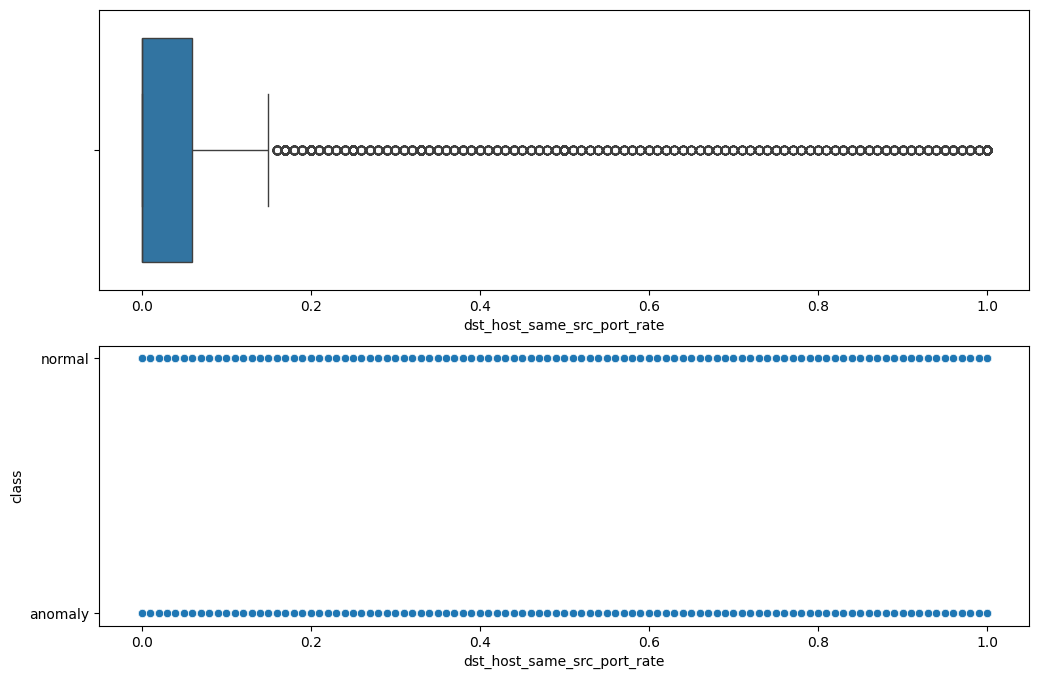

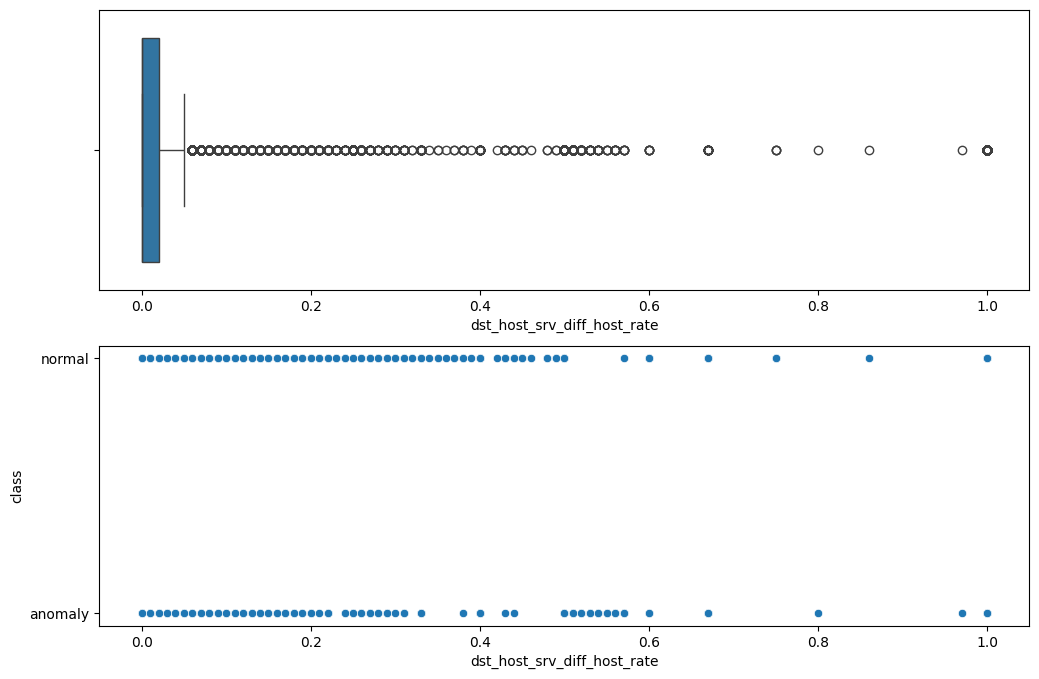

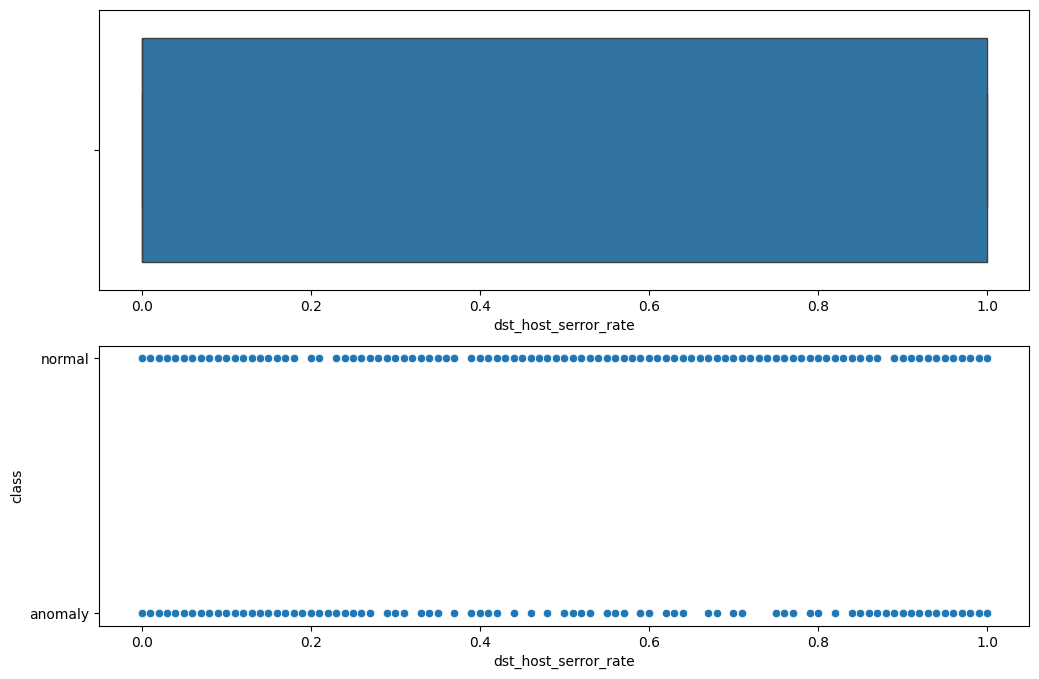

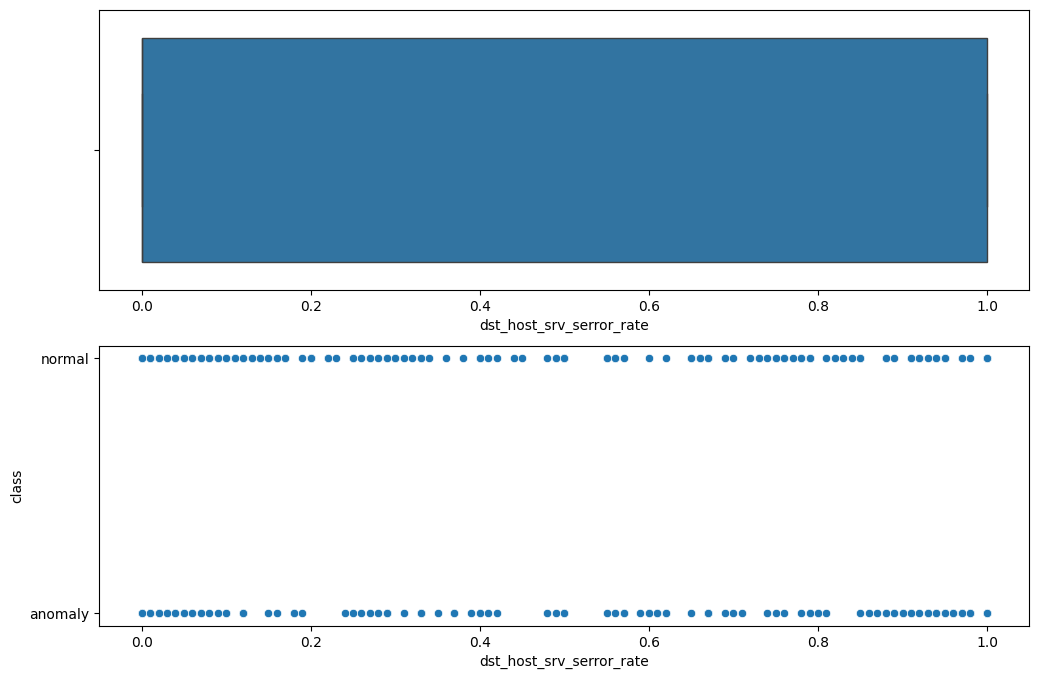

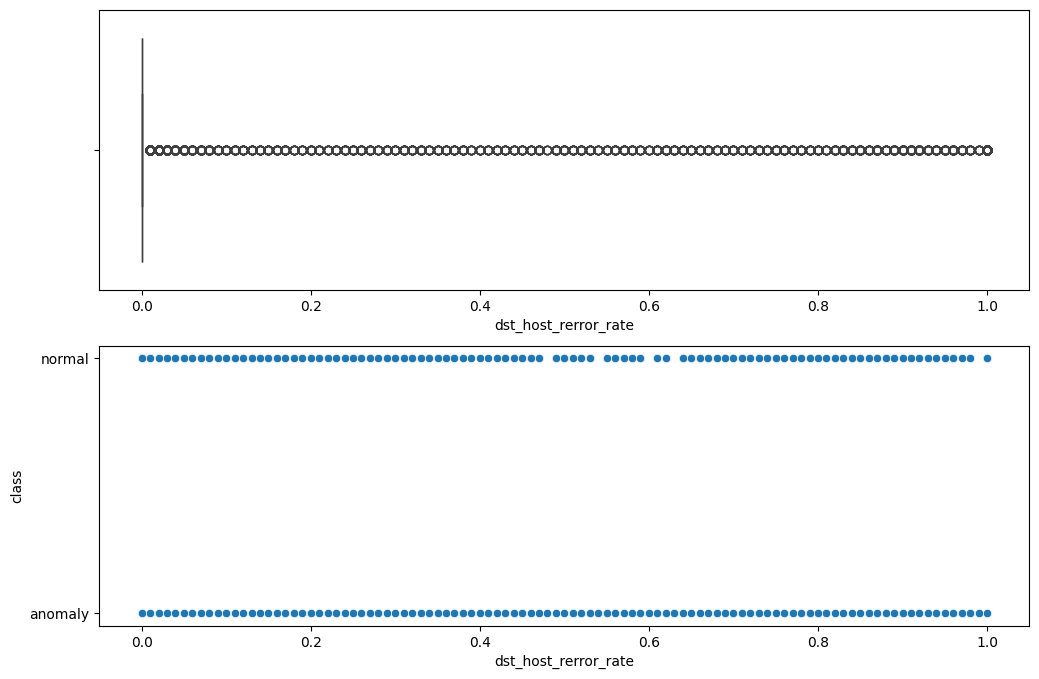

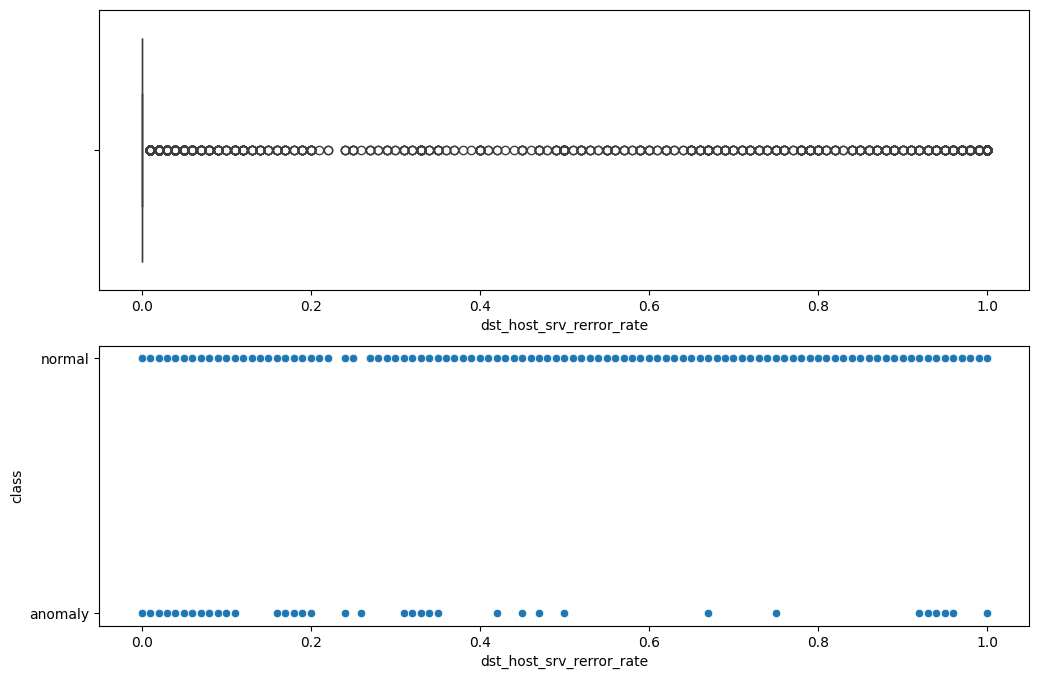

In [ ]:
 for col in df:
     if col != 'class' and is_numeric_dtype(df[col]):
         fig, ax = plt.subplots(2, 1, figsize=(12, 8))
         g1 = sns.boxplot(x = df[col], ax=ax[0])
         g2 = sns.scatterplot(data=df, x=df[col],y=df['class'], ax=ax[1])
         plt.show()

In [ ]:
df = train.copy()

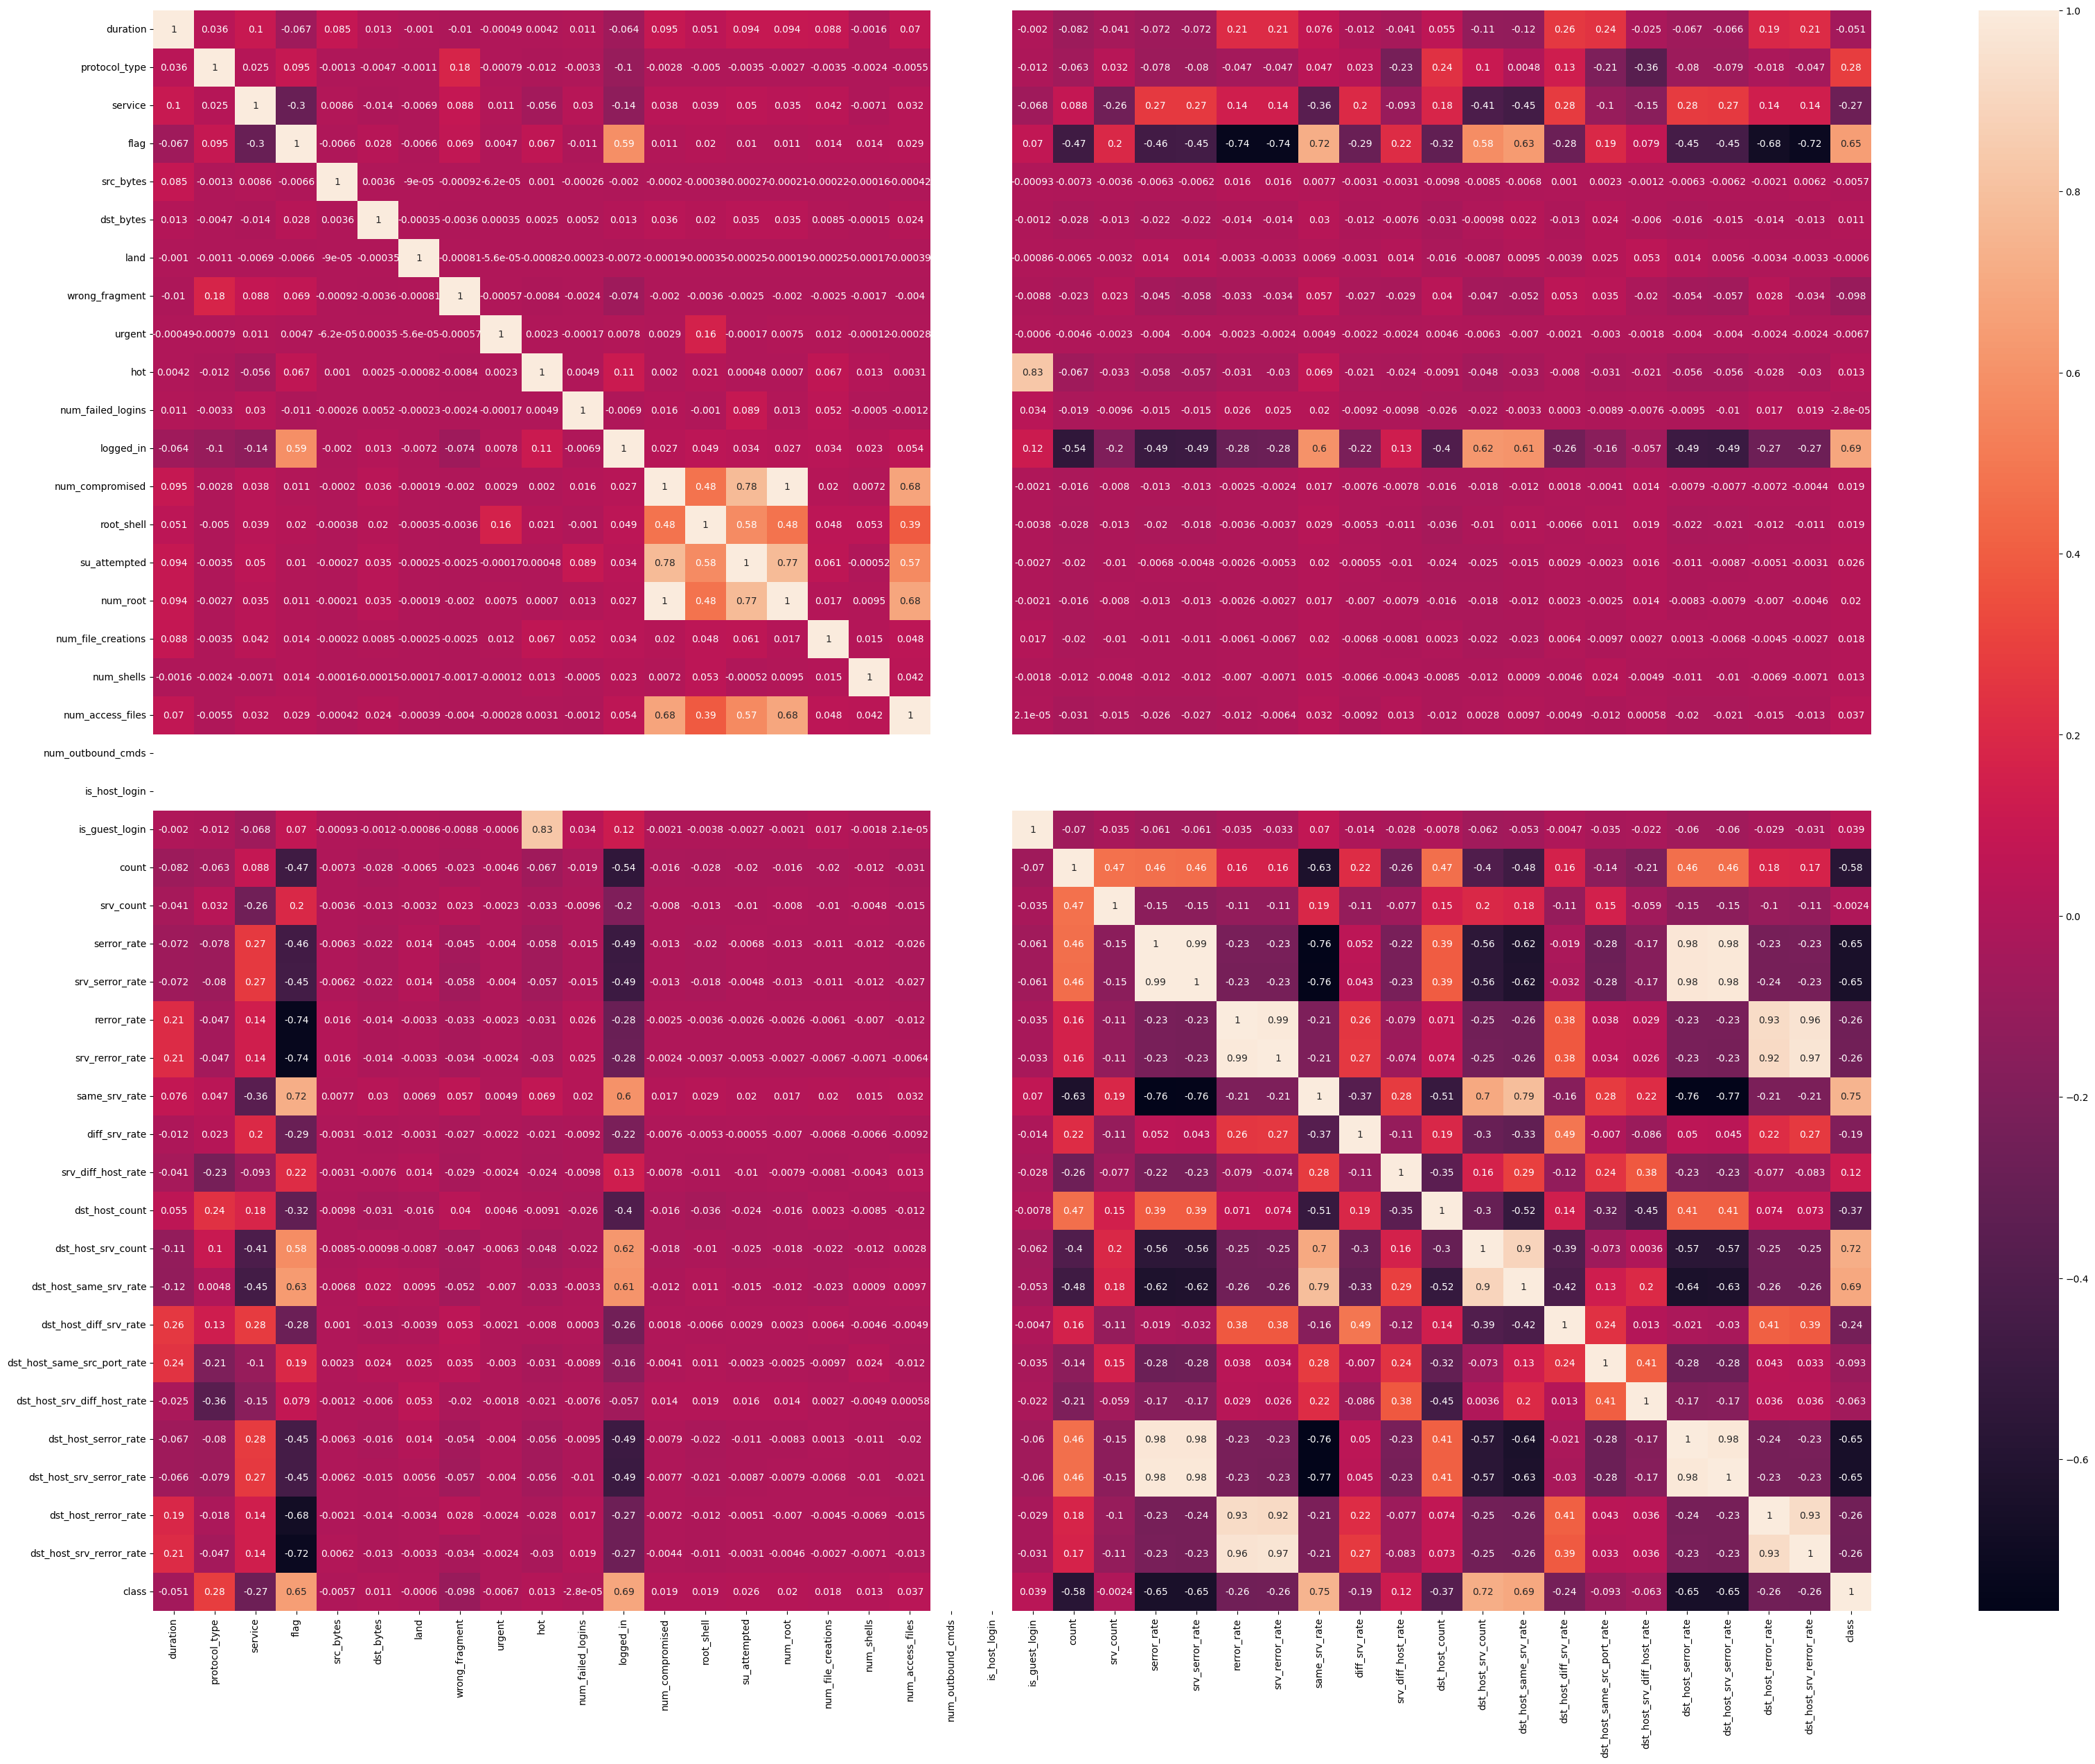

In [ ]:
plt.figure(figsize=(40,30))

# Move the label encoding step here to convert non-numeric columns to numeric
def le(df):
    for col in df.columns:
        if df[col].dtype == 'object':
                label_encoder = LabelEncoder()
                df[col] = label_encoder.fit_transform(df[col])

le(train) # Apply label encoding to the train DataFrame before calculating correlation

sns.heatmap(train.corr(), annot=True)

import plotly.express as px
# Re-apply label encoding to df as well, as it was created as a copy of train before encoding
le(df)
fig = px.imshow(df.corr(), text_auto=True, aspect="auto")
fig.show()

<Axes: xlabel='class', ylabel='count'>

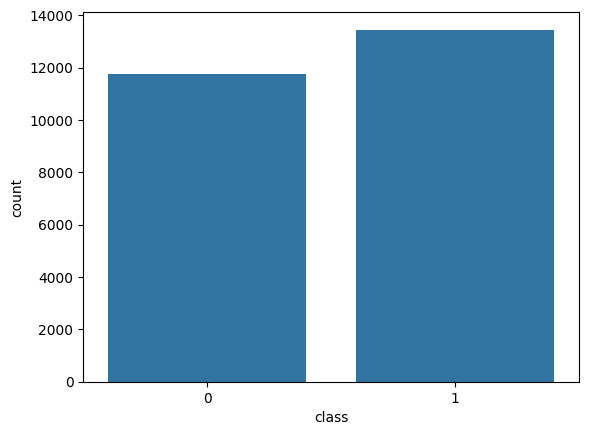

In [ ]:
sns.countplot(x=train['class'])


# Label Encoding

In [ ]:
def le(df):
    for col in df.columns:
        if df[col].dtype == 'object':
                label_encoder = LabelEncoder()
                df[col] = label_encoder.fit_transform(df[col])

le(train)
le(test)

In [ ]:
train.drop(['num_outbound_cmds'], axis=1, inplace=True)
test.drop(['num_outbound_cmds'], axis=1, inplace=True)
train.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,1,19,9,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,1
1,0,2,41,9,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,1
2,0,1,46,5,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,0
3,0,1,22,9,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,1
4,0,1,22,9,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1


#Feature Selection

In [ ]:
X_train = train.drop(['class'], axis=1)
Y_train = train['class']

In [ ]:
rfc = RandomForestClassifier()

rfe = RFE(rfc, n_features_to_select=10)
rfe = rfe.fit(X_train, Y_train)

feature_map = [(i, v) for i, v in itertools.zip_longest(rfe.get_support(), X_train.columns)]
selected_features = [v for i, v in feature_map if i==True]

selected_features

['protocol_type',
 'service',
 'flag',
 'src_bytes',
 'dst_bytes',
 'count',
 'same_srv_rate',
 'diff_srv_rate',
 'dst_host_srv_count',
 'dst_host_same_srv_rate']

In [ ]:
X_train = X_train[selected_features]

#Split and scale data

In [ ]:
scale = StandardScaler()
X_train = scale.fit_transform(X_train)
test = scale.fit_transform(test)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, train_size=0.70, random_state=2)

#K Nearest Neighbors (KNN) classification model

In [ ]:
def knn_objective(trial):
    n_neighbors = trial.suggest_int('KNN_n_neighbors', 2, 16, log=False)
    classifier_obj = KNeighborsClassifier(n_neighbors=n_neighbors)
    classifier_obj.fit(x_train, y_train)
    accuracy = classifier_obj.score(x_test, y_test)
    return accuracy

In [ ]:
%pip install optuna

  Using cached optuna-4.6.0-py3-none-any.whl.metadata (17 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 11.1 MB/s eta 0:00:00


In [ ]:
import optuna

study_KNN = optuna.create_study(direction='maximize')
study_KNN.optimize(knn_objective, n_trials=1)
print(study_KNN.best_trial)

[I 2025-11-21 05:24:48,194] A new study created in memory with name: no-name-d1690d4d-8ef5-4a1b-b8d3-f0952365143e
[I 2025-11-21 05:24:49,482] Trial 0 finished with value: 0.9830643027255888 and parameters: {'KNN_n_neighbors': 5}. Best is trial 0 with value: 0.9830643027255888.


FrozenTrial(number=0, state=<TrialState.COMPLETE: 1>, values=[0.9830643027255888], datetime_start=datetime.datetime(2025, 11, 21, 5, 24, 48, 196383), datetime_complete=datetime.datetime(2025, 11, 21, 5, 24, 49, 482844), params={'KNN_n_neighbors': 5}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'KNN_n_neighbors': IntDistribution(high=16, log=False, low=2, step=1)}, trial_id=0, value=None)


In [ ]:
KNN_model = KNeighborsClassifier(n_neighbors=study_KNN.best_trial.params['KNN_n_neighbors'])
KNN_model.fit(x_train, y_train)

KNN_train, KNN_test = KNN_model.score(x_train, y_train), KNN_model.score(x_test, y_test)

print(f"Train Score: {KNN_train}")
print(f"Test Score: {KNN_test}")

Train Score: 0.9872972666439832
Test Score: 0.9830643027255888


#Logistic Regression Model

In [ ]:
lg_model = LogisticRegression(random_state = 42)
lg_model.fit(x_train, y_train)

LogisticRegression(random_state=42)

In [ ]:
lg_train, lg_test = lg_model.score(x_train , y_train), lg_model.score(x_test , y_test)

print(f"Training Score: {lg_train}")
print(f"Test Score: {lg_test}")

Training Score: 0.9288873766587274
Test Score: 0.9233924318602805


#Decision Tree Classifier

In [ ]:
def dt_objective(trial):
    dt_max_depth = trial.suggest_int('dt_max_depth', 2, 32, log=False)
    dt_max_features = trial.suggest_int('dt_max_features', 2, 10, log=False)
    classifier_obj = DecisionTreeClassifier(max_features = dt_max_features, max_depth = dt_max_depth)
    classifier_obj.fit(x_train, y_train)
    accuracy = classifier_obj.score(x_test, y_test)
    return accuracy

In [ ]:
study_dt = optuna.create_study(direction='maximize')
study_dt.optimize(dt_objective, n_trials=30)
print(study_dt.best_trial)

[I 2025-11-21 05:24:53,480] A new study created in memory with name: no-name-9bc0502e-b3cf-430d-b0b8-fc302c3feff3
[I 2025-11-21 05:24:53,530] Trial 0 finished with value: 0.9929875628473142 and parameters: {'dt_max_depth': 13, 'dt_max_features': 4}. Best is trial 0 with value: 0.9929875628473142.
[I 2025-11-21 05:24:53,680] Trial 1 finished with value: 0.9944429743318338 and parameters: {'dt_max_depth': 27, 'dt_max_features': 9}. Best is trial 1 with value: 0.9944429743318338.
[I 2025-11-21 05:24:53,787] Trial 2 finished with value: 0.9939137337920084 and parameters: {'dt_max_depth': 17, 'dt_max_features': 8}. Best is trial 1 with value: 0.9944429743318338.
[I 2025-11-21 05:24:53,844] Trial 3 finished with value: 0.9923260121725325 and parameters: {'dt_max_depth': 28, 'dt_max_features': 5}. Best is trial 1 with value: 0.9944429743318338.
[I 2025-11-21 05:24:53,943] Trial 4 finished with value: 0.9951045250066155 and parameters: {'dt_max_depth': 16, 'dt_max_features': 6}. Best is trial 

FrozenTrial(number=25, state=<TrialState.COMPLETE: 1>, values=[0.9956337655464409], datetime_start=datetime.datetime(2025, 11, 21, 5, 24, 56, 46199), datetime_complete=datetime.datetime(2025, 11, 21, 5, 24, 56, 154840), params={'dt_max_depth': 13, 'dt_max_features': 10}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'dt_max_depth': IntDistribution(high=32, log=False, low=2, step=1), 'dt_max_features': IntDistribution(high=10, log=False, low=2, step=1)}, trial_id=25, value=None)


In [ ]:
print(f"DEBUG: study_dt.best_trial.params: {study_dt.best_trial.params}")
dt = DecisionTreeClassifier(max_features = study_dt.best_trial.params['dt_max_features'], max_depth = study_dt.best_trial.params['dt_max_depth'])
dt.fit(x_train, y_train)

dt_train, dt_test = dt.score(x_train, y_train), dt.score(x_test, y_test)

print(f"Train Score: {dt_train}")
print(f"Test Score: {dt_test}")

DEBUG: study_dt.best_trial.params: {'dt_max_depth': 13, 'dt_max_features': 10}
Train Score: 0.9997164568447318
Test Score: 0.9952368351415718


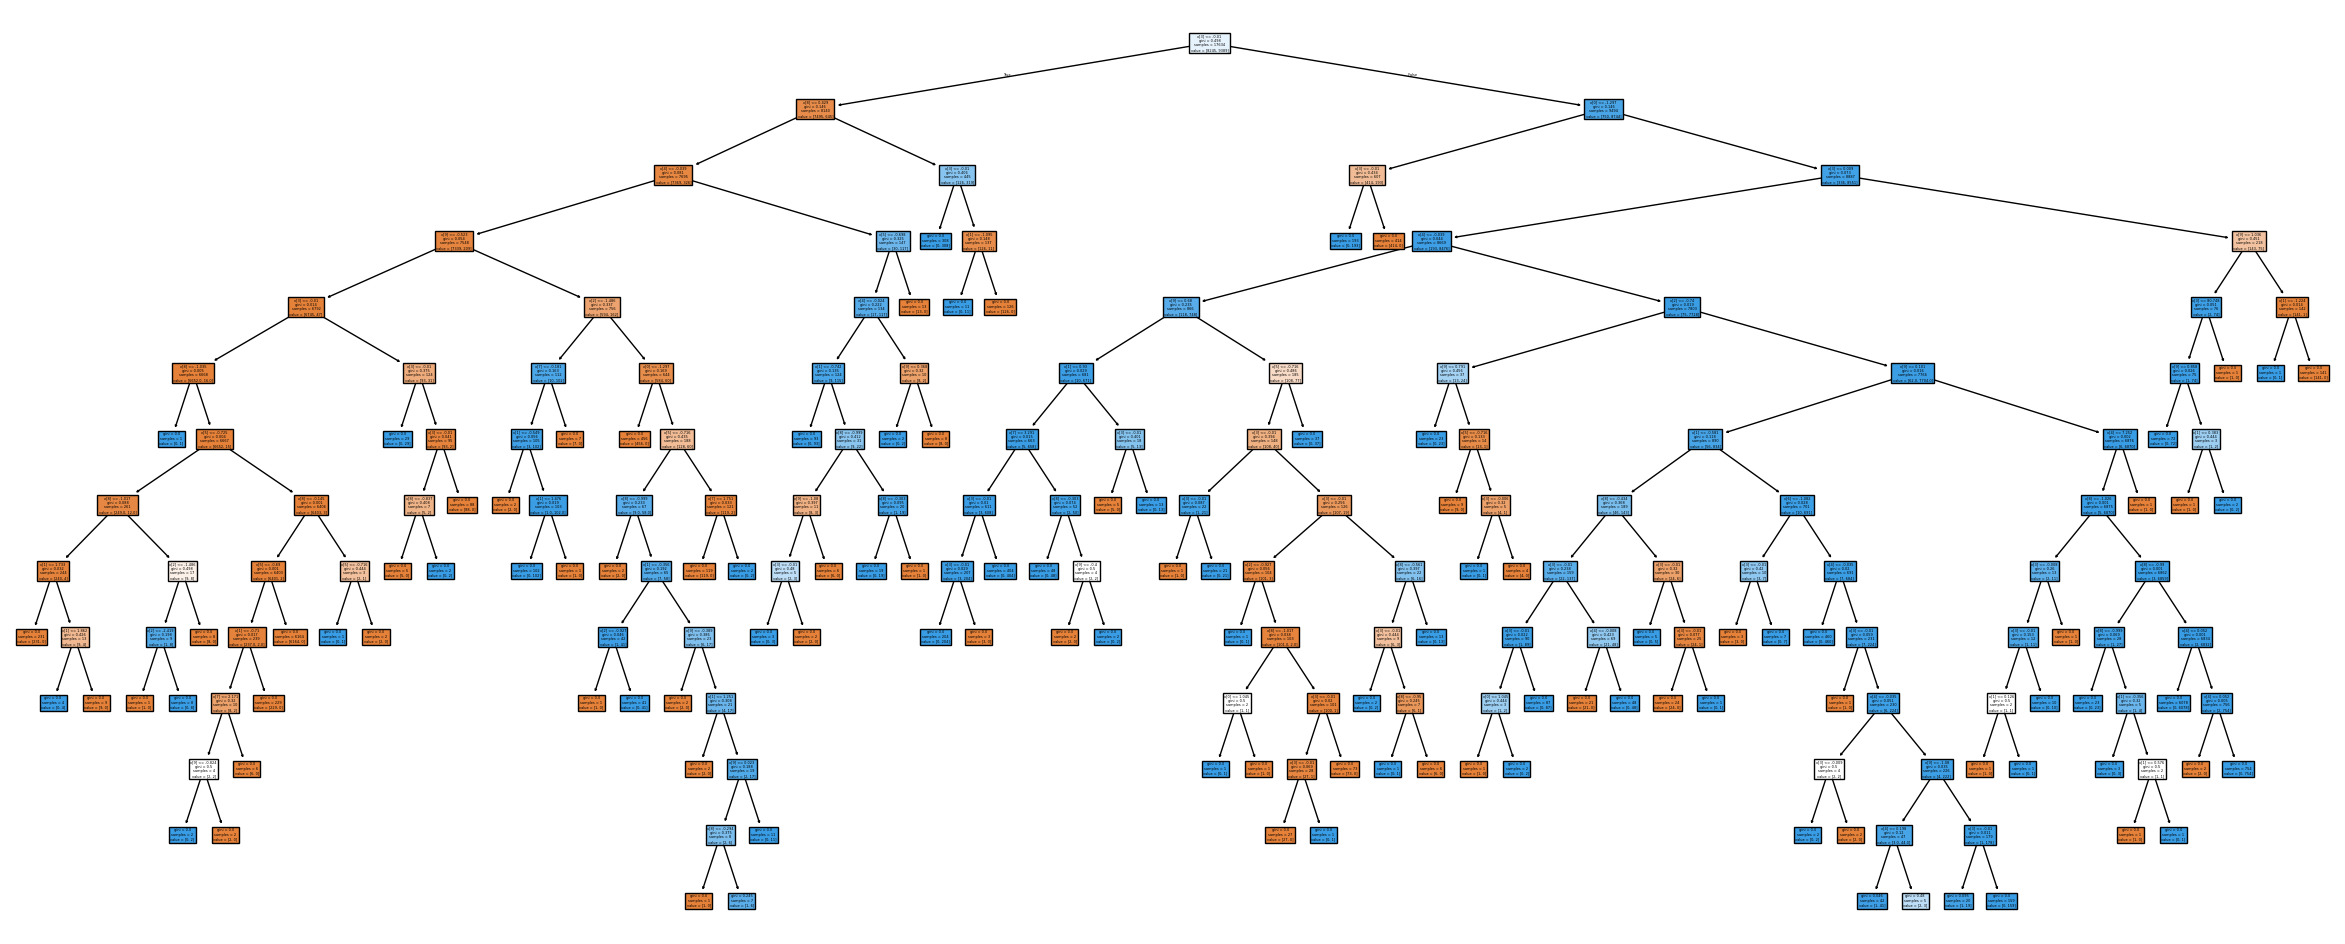

In [ ]:
fig = plt.figure(figsize = (30,12))
tree.plot_tree(dt, filled=True);
plt.show()

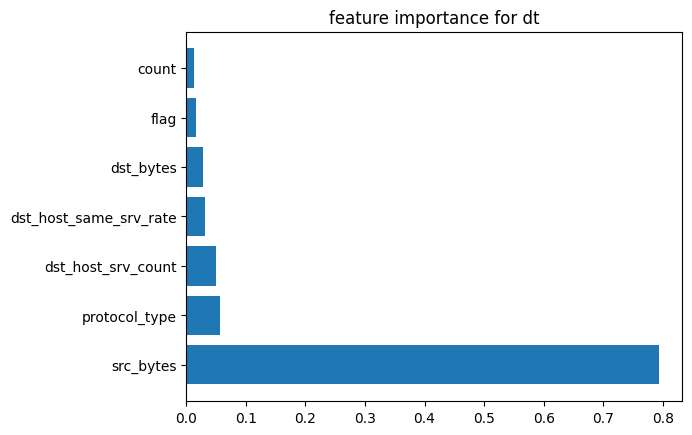

In [ ]:
from matplotlib import pyplot as plt

def f_importance(coef, names, top=-1):
    imp = coef
    imp, names = zip(*sorted(list(zip(imp, names))))

    # Show all features
    if top == -1:
        top = len(names)

    plt.barh(range(top), imp[::-1][0:top], align='center')
    plt.yticks(range(top), names[::-1][0:top])
    plt.title('feature importance for dt')
    plt.show()

# whatever your features are called
features_names = selected_features

# Specify your top n features you want to visualize.
# You can also discard the abs() function
# if you are interested in negative contribution of features
f_importance(abs(dt.feature_importances_), features_names, top=7)


#Random Forest Classifier

In [ ]:
def objective(trial):
    rf_max_depth = trial.suggest_int('rf_max_depth', 2, 32, log=False)
    rf_max_features = trial.suggest_int('rf_max_features', 2, 10, log=False)
    rf_n_estimators = trial.suggest_int('rf_n_estimators', 3, 20, log=False)
    classifier_obj = RandomForestClassifier(max_features = rf_max_features, max_depth = rf_max_depth, n_estimators = rf_n_estimators)
    classifier_obj.fit(x_train, y_train)
    accuracy = classifier_obj.score(x_test, y_test)
    return accuracy


In [ ]:
study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective, n_trials=30)
print(study_rf.best_trial)


[I 2025-11-21 05:25:10,358] A new study created in memory with name: no-name-9934a928-595c-4eb4-b38e-1345beef44ac
[I 2025-11-21 05:25:10,492] Trial 0 finished with value: 0.9473405662873776 and parameters: {'rf_max_depth': 2, 'rf_max_features': 10, 'rf_n_estimators': 5}. Best is trial 0 with value: 0.9473405662873776.
[I 2025-11-21 05:25:11,067] Trial 1 finished with value: 0.9704948399047367 and parameters: {'rf_max_depth': 3, 'rf_max_features': 6, 'rf_n_estimators': 18}. Best is trial 1 with value: 0.9704948399047367.
[I 2025-11-21 05:25:11,744] Trial 2 finished with value: 0.9961630060862662 and parameters: {'rf_max_depth': 16, 'rf_max_features': 5, 'rf_n_estimators': 15}. Best is trial 2 with value: 0.9961630060862662.
[I 2025-11-21 05:25:11,838] Trial 3 finished with value: 0.947869806827203 and parameters: {'rf_max_depth': 2, 'rf_max_features': 5, 'rf_n_estimators': 3}. Best is trial 2 with value: 0.9961630060862662.
[I 2025-11-21 05:25:13,100] Trial 4 finished with value: 0.9964

FrozenTrial(number=12, state=<TrialState.COMPLETE: 1>, values=[0.9965599364911352], datetime_start=datetime.datetime(2025, 11, 21, 5, 25, 19, 445254), datetime_complete=datetime.datetime(2025, 11, 21, 5, 25, 20, 164560), params={'rf_max_depth': 14, 'rf_max_features': 6, 'rf_n_estimators': 15}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'rf_max_depth': IntDistribution(high=32, log=False, low=2, step=1), 'rf_max_features': IntDistribution(high=10, log=False, low=2, step=1), 'rf_n_estimators': IntDistribution(high=20, log=False, low=3, step=1)}, trial_id=12, value=None)


In [ ]:
rf = RandomForestClassifier(max_features = study_rf.best_trial.params['rf_max_features'], max_depth = study_rf.best_trial.params['rf_max_depth'], n_estimators = study_rf.best_trial.params['rf_n_estimators'])
rf.fit(x_train, y_train)

rf_train, rf_test = rf.score(x_train, y_train), rf.score(x_test, y_test)

print(f"Train Score: {rf_train}")
print(f"Test Score: {rf_test}")

Train Score: 0.9998298741068391
Test Score: 0.9964276263561789


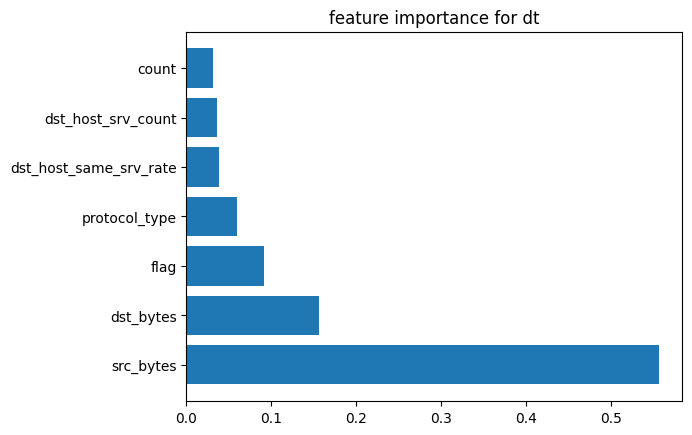

In [ ]:
from matplotlib import pyplot as plt

def f_importance(coef, names, top=-1):
    imp = coef
    imp, names = zip(*sorted(list(zip(imp, names))))

    # Show all features
    if top == -1:
        top = len(names)

    plt.barh(range(top), imp[::-1][0:top], align='center')
    plt.yticks(range(top), names[::-1][0:top])
    plt.title('feature importance for dt')
    plt.show()

# whatever your features are called
features_names = selected_features

# Specify your top n features you want to visualize.
# You can also discard the abs() function
# if you are interested in negative contribution of features
f_importance(abs(rf.feature_importances_), features_names, top=7)

#SKLearn Gradient Boosting Model

In [ ]:
SKGB = GradientBoostingClassifier(random_state=42)
SKGB.fit(x_train, y_train)


GradientBoostingClassifier(random_state=42)

In [ ]:
SKGB_train, SKGB_test = SKGB.score(x_train , y_train), SKGB.score(x_test , y_test)

print(f"Training Score: {SKGB_train}")
print(f"Test Score: {SKGB_test}")

Training Score: 0.9947828059430646
Test Score: 0.9927229425774015


#XGBoost Gradient Boosting Model

In [ ]:
xgb_model = XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(x_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
xgb_train, xgb_test = xgb_model.score(x_train , y_train), xgb_model.score(x_test , y_test)

print(f"Training Score: {xgb_train}")
print(f"Test Score: {xgb_test}")

Training Score: 1.0
Test Score: 0.9960306959513099


#Light Gradient Boosting Model

In [ ]:
lgb_model = LGBMClassifier(random_state=42)
lgb_model.fit(x_train, y_train)

[LightGBM] [Info] Number of positive: 9389, number of negative: 8245
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1301
[LightGBM] [Info] Number of data points in the train set: 17634, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.532437 -> initscore=0.129932
[LightGBM] [Info] Start training from score 0.129932


LGBMClassifier(random_state=42)

In [ ]:
lgb_train, lgb_test = lgb_model.score(x_train , y_train), lgb_model.score(x_test , y_test)

print(f"Training Score: {lgb_train}")
print(f"Test Score: {lgb_test}")

Training Score: 1.0
Test Score: 0.9965599364911352


#SKLearn AdaBoost Model

In [ ]:
ab_model = AdaBoostClassifier(random_state=42)

In [ ]:
ab_model.fit(x_train, y_train)



AdaBoostClassifier(random_state=42)

In [ ]:
ab_train, ab_test = ab_model.score(x_train , y_train), ab_model.score(x_test , y_test)

print(f"Training Score: {ab_train}")
print(f"Test Score: {ab_test}")

Training Score: 0.9735170692979471
Test Score: 0.9726118020640381


#CatBoost Classifier Model

In [ ]:
cb_model = CatBoostClassifier(verbose=0)




In [ ]:
cb_model.fit(x_train, y_train)

In [ ]:
cb_train, cb_test = cb_model.score(x_train , y_train), cb_model.score(x_test , y_test)

print(f"Training Score: {cb_train}")
print(f"Test Score: {cb_test}")

Training Score: 0.9985822842236588
Test Score: 0.9956337655464409


#Naive Baye Model

In [ ]:
BNB_model = BernoulliNB()
BNB_model.fit(x_train, y_train)


BernoulliNB()

In [ ]:

BNB_train, BNB_test = BNB_model.score(x_train , y_train), BNB_model.score(x_test , y_test)

print(f"Training Score: {BNB_train}")
print(f"Test Score: {BNB_test}")

Training Score: 0.8975842123171147
Test Score: 0.8970627150039693


#Voting Model

In [ ]:
v_clf = VotingClassifier(estimators=[('KNeighborsClassifier', KNN_model), ("XGBClassifier", xgb_model), ("RandomForestClassifier", rf), ("DecisionTree", dt), ("XGBoost", xgb_model), ("LightGB", lgb_model), ("AdaBoost", ab_model), ("Catboost", cb_model)], voting = "hard")


In [ ]:
v_clf.fit(x_train, y_train)

[LightGBM] [Info] Number of positive: 9389, number of negative: 8245
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000734 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1301
[LightGBM] [Info] Number of data points in the train set: 17634, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.532437 -> initscore=0.129932
[LightGBM] [Info] Start training from score 0.129932


VotingClassifier(estimators=[('KNeighborsClassifier', KNeighborsClassifier()),
                             ('XGBClassifier',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            feature_weights=None, gamma=None...
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None, ...)),
                             ('LightGB', LGBMClassifier(random_state=42)),
                             ('AdaBoost', AdaBoostClassifier(random_state=42)),
                             ('Catboost',
                              <catboost.core.CatBoostClassifier object at 0x7f57e614e270>)])

In [ ]:
voting_train, voting_test = v_clf.score(x_train , y_train), v_clf.score(x_test , y_test)

print(f"Training Score: {voting_train}")
print(f"Test Score: {voting_test}")

Training Score: 0.9999432913689463
Test Score: 0.9966922466260916


#SVM Model

In [ ]:
def objective(trial):
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly', 'linearSVC'])
    c = trial.suggest_float('c', 0.02, 1.0, step=0.02)
    if kernel in ['linear', 'rbf']:
        classifier_obj = SVC(kernel=kernel, C=c).fit(x_train, y_train)
    elif kernel == 'linearSVC':
        classifier_obj = LinearSVC(C=c).fit(x_train, y_train)
    elif kernel == 'poly':
        degree = trial.suggest_int('degree', 2, 10)
        classifier_obj = SVC(kernel=kernel, C=c, degree=degree).fit(x_train, y_train)

    accuracy = classifier_obj.score(x_test, y_test)
    return accuracy


In [ ]:
study_svm = optuna.create_study(direction='maximize')
study_svm.optimize(objective, n_trials=30)
print(study_svm.best_trial)

[I 2025-11-21 05:25:53,843] A new study created in memory with name: no-name-388ecdd1-dc8f-496d-bb9d-09527fe9adbb
[I 2025-11-21 05:25:53,878] Trial 0 finished with value: 0.926700185234189 and parameters: {'kernel': 'linearSVC', 'c': 0.28}. Best is trial 0 with value: 0.926700185234189.
[I 2025-11-21 05:25:59,976] Trial 1 finished with value: 0.9321249007673987 and parameters: {'kernel': 'linear', 'c': 0.28}. Best is trial 1 with value: 0.9321249007673987.
[I 2025-11-21 05:26:02,655] Trial 2 finished with value: 0.969833289229955 and parameters: {'kernel': 'rbf', 'c': 0.5800000000000001}. Best is trial 2 with value: 0.969833289229955.
[I 2025-11-21 05:26:02,687] Trial 3 finished with value: 0.926700185234189 and parameters: {'kernel': 'linearSVC', 'c': 0.26}. Best is trial 2 with value: 0.969833289229955.
[I 2025-11-21 05:26:02,717] Trial 4 finished with value: 0.926700185234189 and parameters: {'kernel': 'linearSVC', 'c': 0.4}. Best is trial 2 with value: 0.969833289229955.
[I 2025-11

FrozenTrial(number=12, state=<TrialState.COMPLETE: 1>, values=[0.9708917703096057], datetime_start=datetime.datetime(2025, 11, 21, 5, 26, 34, 831181), datetime_complete=datetime.datetime(2025, 11, 21, 5, 26, 38, 827081), params={'kernel': 'rbf', 'c': 0.9}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'kernel': CategoricalDistribution(choices=('linear', 'rbf', 'poly', 'linearSVC')), 'c': FloatDistribution(high=1.0, log=False, low=0.02, step=0.02)}, trial_id=12, value=None)


In [ ]:
if study_svm.best_trial.params['kernel'] in ['linear', 'rbf']:
    SVM_model = SVC(kernel=study_svm.best_trial.params['kernel'], C=study_svm.best_trial.params['c'])
elif kernel == 'linearSVC':
    SVM_model = LinearSVC(C=study_svm.best_trial.params['c'])
elif kernel == 'poly':
    SVM_model = SVC(kernel=study_svm.best_trial.params['kernel'], C=study_svm.best_trial.params['c'], degree=study_svm.best_trial.params['degree'])

SVM_model.fit(x_train, y_train)



SVC(C=0.9)

In [ ]:
SVM_train, SVM_test = SVM_model.score(x_train , y_train), SVM_model.score(x_test , y_test)

print(f"Training Score: {SVM_train}")
print(f"Test Score: {SVM_test}")

Training Score: 0.9681864579789043
Test Score: 0.9708917703096057


#Summary

In [ ]:
data = [["KNN", KNN_train, KNN_test],
        ["Logistic Regression", lg_train, lg_test],
        ["Decision Tree", dt_train, dt_test],
        ["Random Forest", rf_train, rf_test],
        ["GBM", SKGB_train, SKGB_test],
        ["XGBM", xgb_train, xgb_test],
        ["Adaboost", ab_train, ab_test],
        ["light GBM", lgb_train, lgb_test],
        ["CatBoost", cb_train, cb_test],
        ["Naive Baye Model", BNB_train, BNB_test],
        ["Voting", voting_train, voting_test],
        ["SVM", SVM_train, SVM_test]]

col_names = ["Model", "Train Score", "Test Score"]
print(tabulate(data, headers=col_names, tablefmt="fancy_grid"))

╒═════════════════════╤═══════════════╤══════════════╕
│ Model               │   Train Score │   Test Score │
╞═════════════════════╪═══════════════╪══════════════╡
│ KNN                 │      0.987297 │     0.983064 │
├─────────────────────┼───────────────┼──────────────┤
│ Logistic Regression │      0.928887 │     0.923392 │
├─────────────────────┼───────────────┼──────────────┤
│ Decision Tree       │      0.999716 │     0.995237 │
├─────────────────────┼───────────────┼──────────────┤
│ Random Forest       │      0.99983  │     0.996428 │
├─────────────────────┼───────────────┼──────────────┤
│ GBM                 │      0.994783 │     0.992723 │
├─────────────────────┼───────────────┼──────────────┤
│ XGBM                │      1        │     0.996031 │
├─────────────────────┼───────────────┼──────────────┤
│ Adaboost            │      0.973517 │     0.972612 │
├─────────────────────┼───────────────┼──────────────┤
│ light GBM           │      1        │     0.99656  │
├─────────